# Imports

In [121]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
from scipy.stats import skew, kurtosis
import pandas as pd
from sklearn.feature_selection import RFE

from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, PredefinedSplit, LeaveOneGroupOut, LeavePGroupsOut
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


PROJECT_ROOT = Path(os.path.abspath(__file__)).parent if '__file__' in globals() else Path.cwd()
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
EMG_DIR = os.path.join(DATA_DIR, "EMG")
OUT_DIR = os.path.join(PROJECT_ROOT, "output")

EMG_OUTPUT_DIR = os.path.join(OUT_DIR, "emg")
os.makedirs(EMG_OUTPUT_DIR, exist_ok=True)

np.random.seed(42)

# Part 1: Single subject classification

## Loading data

In [122]:
def load_and_save_raw_data(subject_id='s2', base_dir='data/emg', output_dir='data/output'):
    s2_dir = Path(base_dir) / subject_id
    output_s2_dir = Path(output_dir) / subject_id
    os.makedirs(output_s2_dir, exist_ok=True)

    # 1. Locate the .mat file
    ex1_file = sorted(s2_dir.glob(f'{subject_id.upper()}_A1_E1.mat'))
    
    if not ex1_file:
        # Fallback check for different casing if necessary, or just raise error
        # Assuming standard Ninapro naming like S2_A1_E1.mat
        raise FileNotFoundError(f'{subject_id.upper()}_A1_E1.mat not found under {s2_dir}')
    
    ex1_path = ex1_file[0]
    print(f"Loading raw file: {ex1_path.name}")
    
    mat_ex1 = loadmat(ex1_path, squeeze_me=True)

    # 2. Extract Fields safely
    subject = np.asarray(mat_ex1.get('subject')) if 'subject' in mat_ex1 else None
    exercise = np.asarray(mat_ex1.get('exercise')) if 'exercise' in mat_ex1 else None
    stimulus = np.asarray(mat_ex1.get('stimulus')) if 'stimulus' in mat_ex1 else None
    restimulus = np.asarray(mat_ex1.get('restimulus')) if 'restimulus' in mat_ex1 else None
    repetition = np.asarray(mat_ex1.get('repetition')) if 'repetition' in mat_ex1 else None
    rerepetition = np.asarray(mat_ex1.get('rerepetition')) if 'rerepetition' in mat_ex1 else None
    emg_ex1 = np.asarray(mat_ex1['emg'])
    glove = np.asarray(mat_ex1.get('glove')) if 'glove' in mat_ex1 else None
    
    # Handle fs (sampling frequency)
    fs_val = mat_ex1.get('fs', None)
    fs_ex1 = float(np.asarray(fs_val).squeeze()) if fs_val is not None else 100.0

    # 3. Save to .npz
    out_path = output_s2_dir / f'{subject_id}_ex1_raw.npz'
    np.savez(
        out_path,
        subject=subject,
        exercise=exercise,
        stimulus=stimulus,
        restimulus=restimulus,
        repetition=repetition,
        rerepetition=rerepetition,
        emg=emg_ex1,
        glove=glove,
        fs=fs_ex1,
    )
    print(f'Saved raw data to {out_path}')
    return out_path

In [123]:
s2_dir = Path(EMG_DIR) / 's2'

mat_files = sorted(s2_dir.glob('S2_*.mat'))
print(f'found {len(mat_files)} .mat files for subject 2')
for f in mat_files:
    m = loadmat(f, squeeze_me=True)
    keys = [k for k in m.keys() if not k.startswith('__')]
    print(f'\n{f.name}: keys -> {keys}')
    emg_key = next((k for k in keys if 'emg' in k.lower()), None)
    if emg_key:
        emg = m[emg_key]
        print(f'  {emg_key} shape: {np.shape(emg)}')
    restimulus = m.get('restimulus', None)
    if restimulus is not None:
        rs = np.asarray(restimulus).ravel()
        print(f'  unique stimulus labels: {np.unique(rs)}')
    rerepetition = m.get('rerepetition', None)
    if rerepetition is not None:
        rr = np.asarray(rerepetition).ravel()
        print(f'  repetitions: {np.unique(rr)}')

load_and_save_raw_data(subject_id='s2', base_dir=EMG_DIR, output_dir=EMG_DIR)

found 3 .mat files for subject 2

S2_A1_E1.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (100686, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]

S2_A1_E2.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (142731, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]

S2_A1_E3.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (229084, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]
Loading raw file: S2_A1_E1.mat
Saved raw data to /Users/bui/code/NX-421-project/data/EMG/s2/s2_ex1_raw.npz


PosixPath('/Users/bui/code/NX-421-project/data/EMG/s2/s2_ex1_raw.npz')

### Visualize data before processing

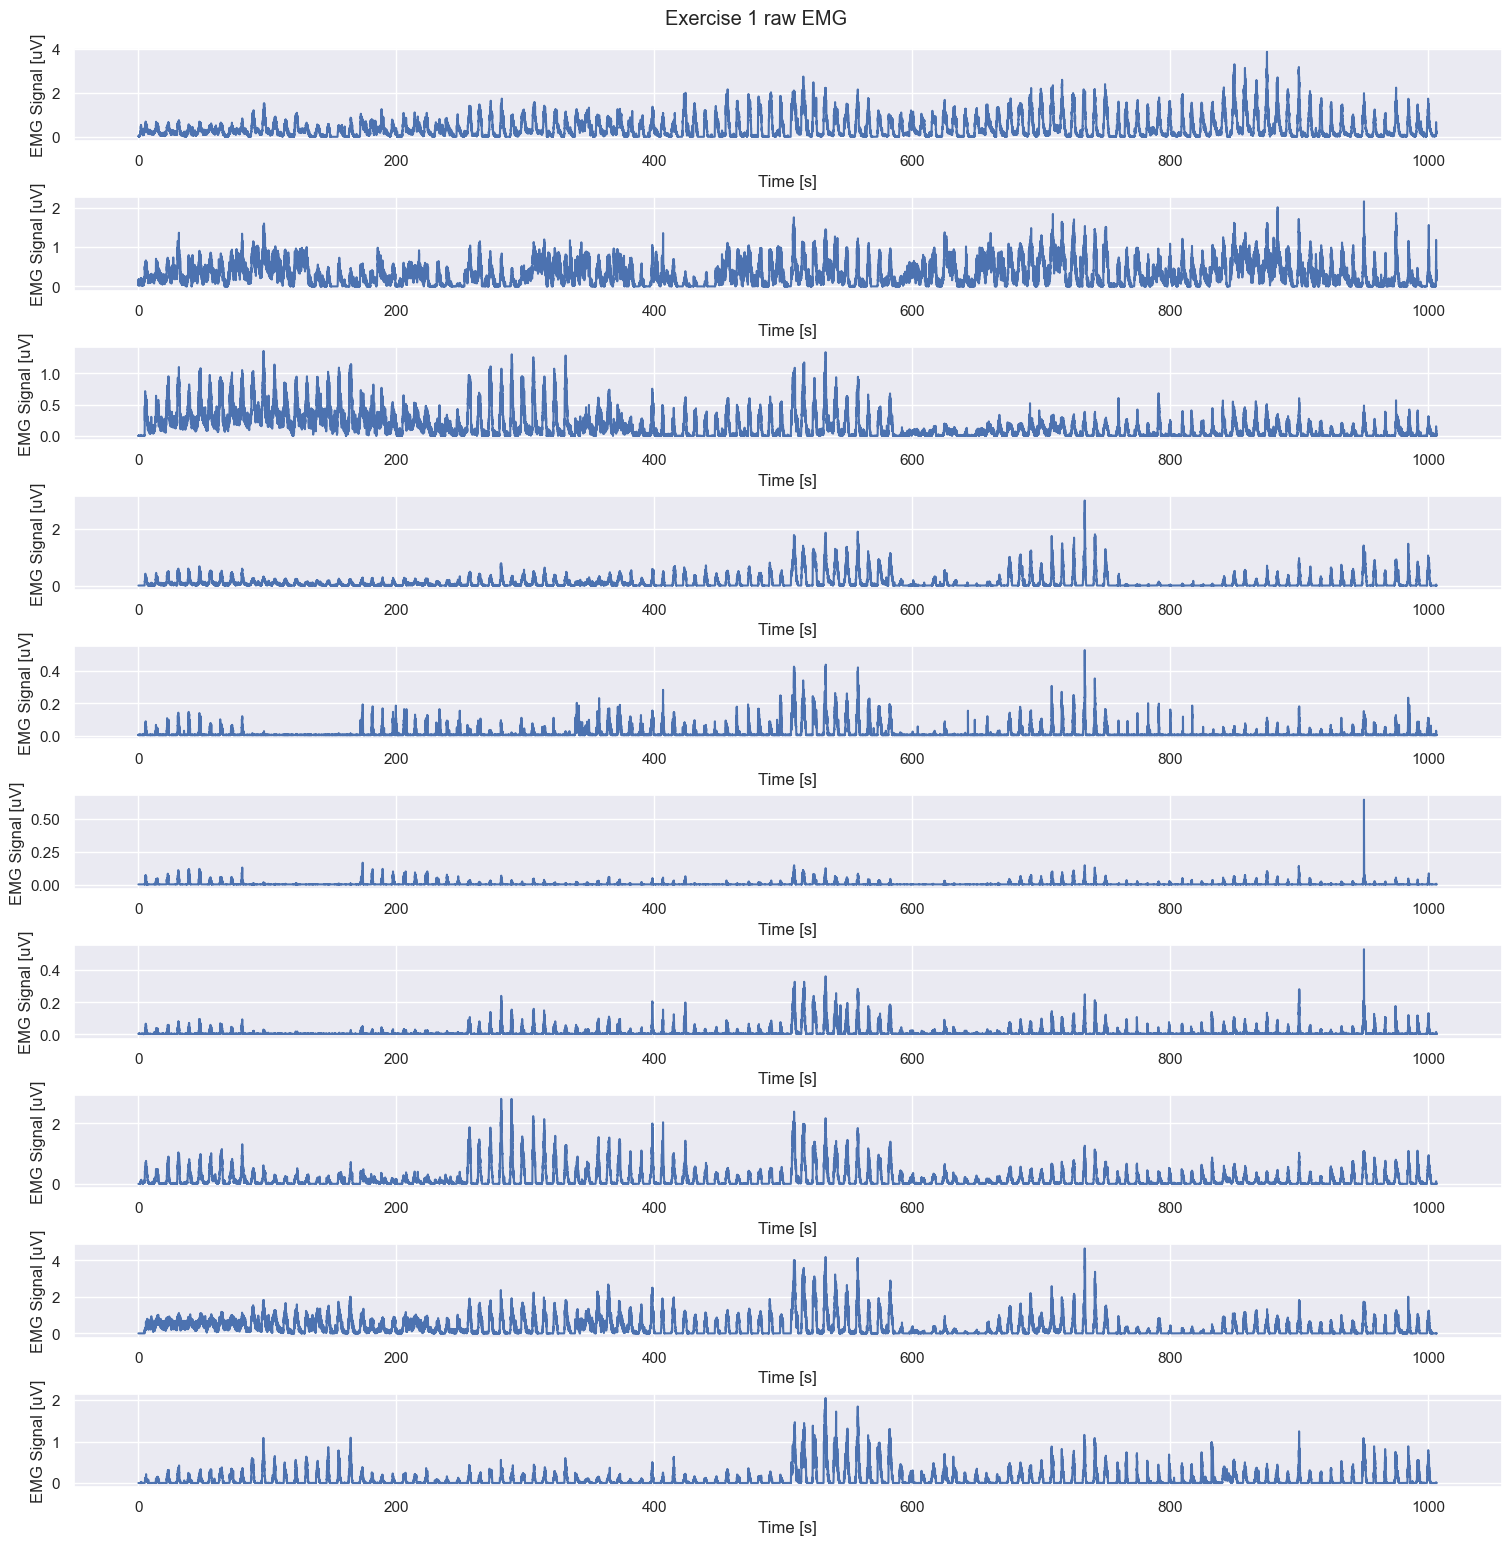

In [124]:
s2_a1_e1_path = Path(EMG_DIR) / 's2' / 's2_ex1_raw.npz'
raw = np.load(s2_a1_e1_path)
emg_raw = raw['emg']
fs = float(raw['fs'])
n_channels = emg_raw.shape[1]
time_steps = np.arange(emg_raw.shape[0]) / fs

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_raw[:, channel_idx])
    ax[channel_idx].set_xlabel('Time [s]')
    ax[channel_idx].set_ylabel('EMG Signal [uV]')
fig.suptitle('Exercise 1 raw EMG', y=1.02)
plt.show()


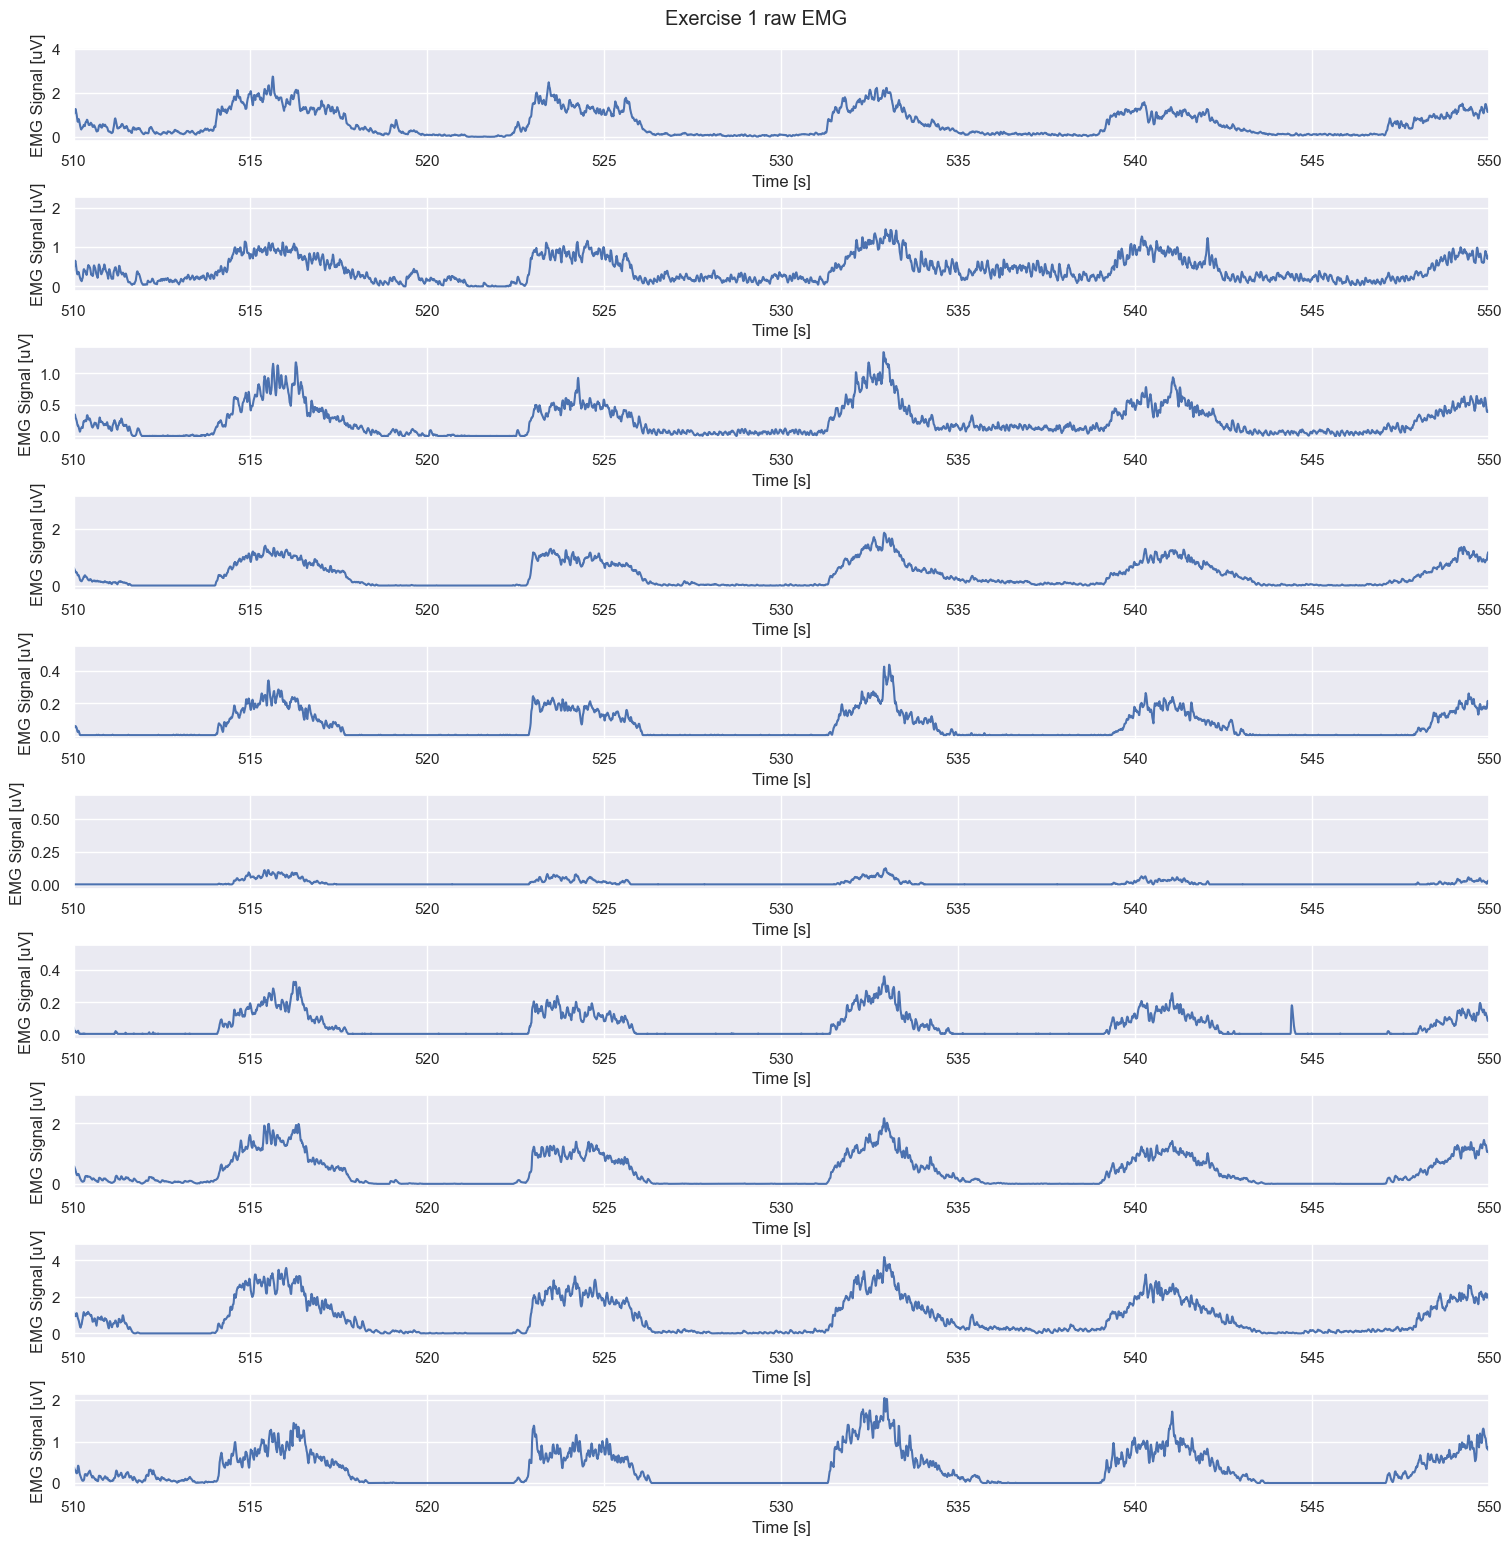

In [135]:
fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_raw[:, channel_idx])
    ax[channel_idx].set_xlim(510, 550)
    ax[channel_idx].set_xlabel('Time [s]')
    ax[channel_idx].set_ylabel('EMG Signal [uV]')
fig.suptitle('Exercise 1 raw EMG', y=1.02)
plt.show()


## Preprocessing

### Low-pass filter at 1Hz to smooth the envelope

From paper: "Before performing the classification, the data from database 1 were preprocessed using a 1st order Butterworth low-pass filter with a 1 Hz cutoff frequency"

In [136]:
def preprocess_emg_data(raw_npz_path, output_dir='data/output'):
    raw_npz_path = Path(raw_npz_path)
    if not raw_npz_path.exists():
        raise FileNotFoundError(f"{raw_npz_path} not found.")

    raw = np.load(raw_npz_path, allow_pickle=True)
    emg = raw['emg']
    fs = float(raw['fs'])
    
    # apply filter (1Hz Low Pass for Envelope)
    sos = butter(N=1, Wn=1, fs=fs, btype='low', output='sos')
    emg_filtered = sosfiltfilt(sos, emg.T).T

    filename_parts = raw_npz_path.stem.split('_')
    subject_id = filename_parts[0] if len(filename_parts) > 0 else 'unknown'
    
    out_dir_full = Path(output_dir) / subject_id
    os.makedirs(out_dir_full, exist_ok=True)
    band_out = out_dir_full / f'{subject_id}_ex1_processed.npz'

    # 3. Save
    np.savez(
        band_out,
        emg=emg_filtered,
        subject=raw.get('subject'),
        exercise=raw.get('exercise'),
        stimulus=raw.get('stimulus'),
        restimulus=raw.get('restimulus'),
        repetition=raw.get('repetition'),
        rerepetition=raw.get('rerepetition'),
        glove=raw.get('glove'),
        fs=fs,
    )
    print(f'Processed (Filtered) data saved to {band_out}')
    return band_out

Processed (Filtered) data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s2\s2_ex1_processed.npz


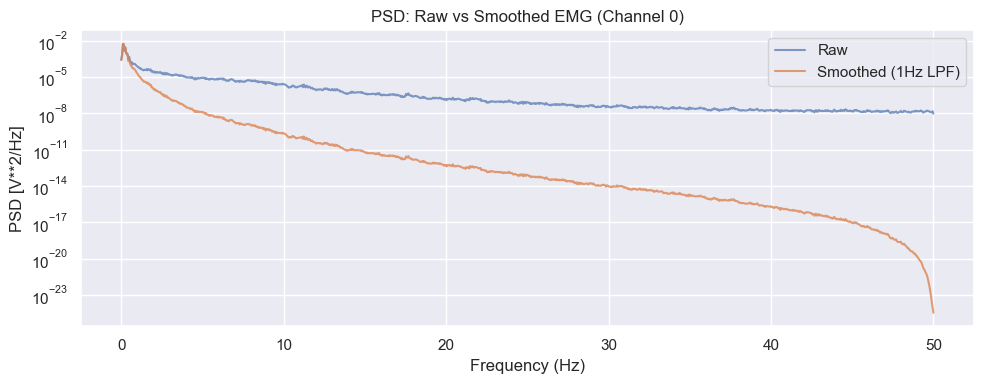

In [137]:
raw_npz_path = Path(EMG_DIR) / 's2' / 's2_ex1_raw.npz'
processed_path = preprocess_emg_data(raw_npz_path, output_dir=EMG_OUTPUT_DIR)

raw = np.load(raw_npz_path)
proc = np.load(processed_path)
emg_raw = raw['emg']
emg_smooth = proc['emg']
fs = float(raw['fs'])

channel_idx = 4

f_raw, psd_raw = welch(emg_raw[:, channel_idx], fs=fs, nperseg=2048)
f_smooth, psd_smooth = welch(emg_smooth[:, channel_idx], fs=fs, nperseg=2048)

plt.figure(figsize=(10, 4))
plt.semilogy(f_raw, psd_raw, label='Raw', alpha=0.7)
plt.semilogy(f_smooth, psd_smooth, label='Smoothed (1Hz LPF)', alpha=0.8)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD [V**2/Hz]')
plt.title('PSD: Raw vs Smoothed EMG (Channel 0)')
plt.legend()
plt.tight_layout()
plt.show()


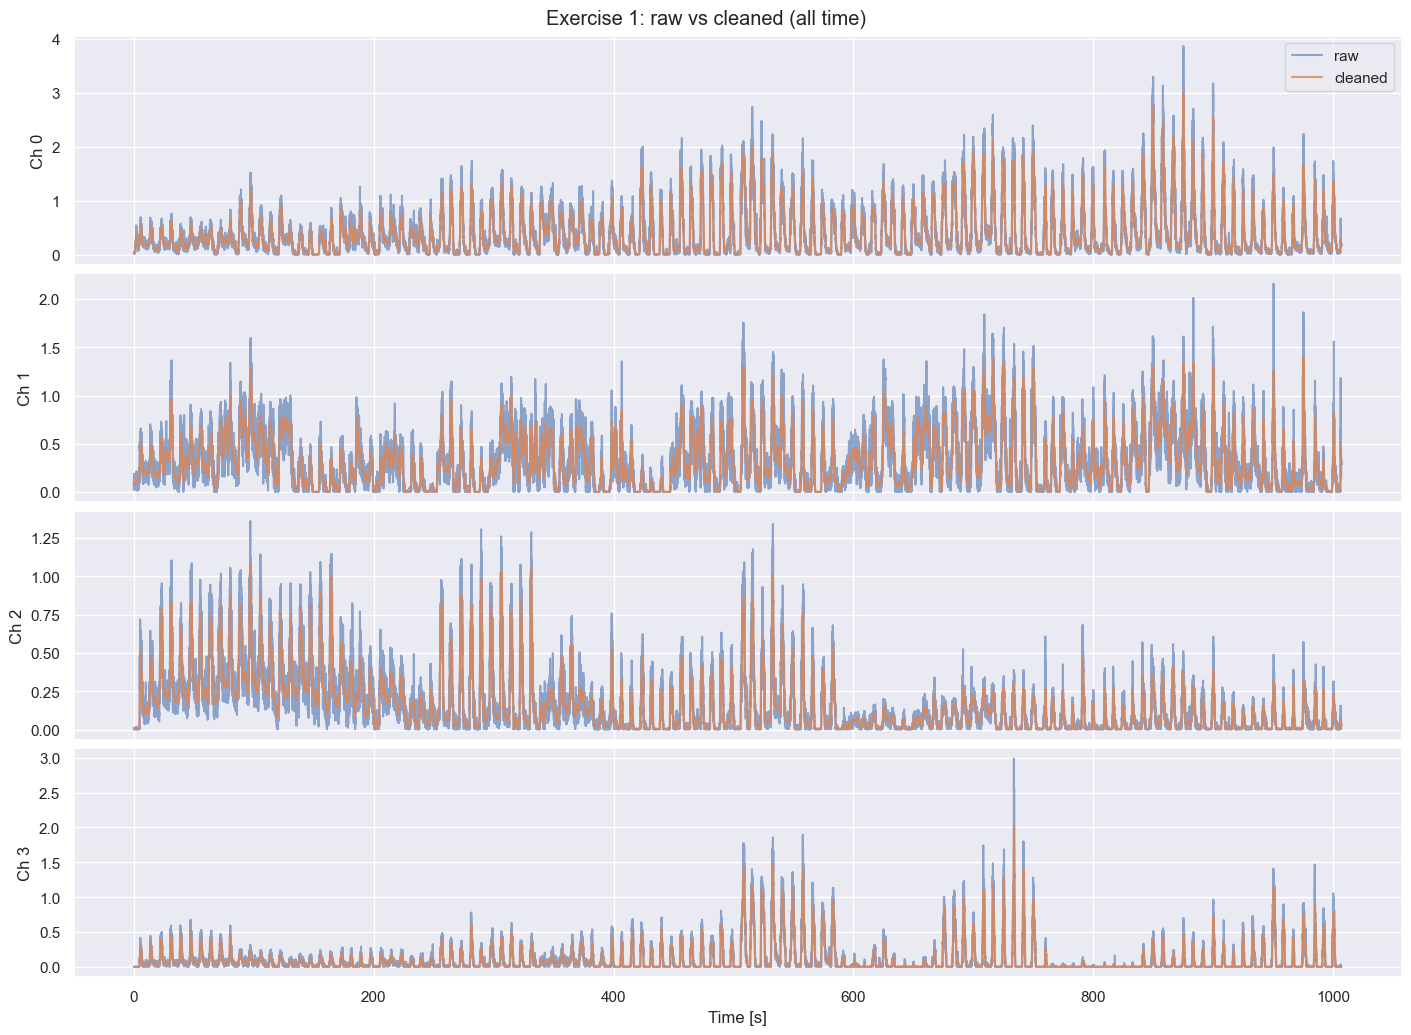

In [126]:
# Overlay raw vs cleaned (all time, first 4 channels)
raw_path = Path(EMG_DIR) / 's2' / 's2_ex1_raw.npz'
proc_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_processed.npz'
raw = np.load(raw_path)
proc = np.load(proc_path)
emg_raw = raw['emg']
emg_clean = proc['emg']
fs = float(raw['fs'])
span = emg_raw.shape[0]  # Plot all samples
channels_to_plot = min(4, emg_raw.shape[1])
t = np.arange(span) / fs

fig, axes = plt.subplots(channels_to_plot, 1, figsize=(14, 10), sharex=True, constrained_layout=True)
for i in range(channels_to_plot):
    axes[i].plot(t, emg_raw[:span, i], label='raw', alpha=0.6)
    axes[i].plot(t, emg_clean[:span, i], label='cleaned', alpha=0.8)
    axes[i].set_ylabel(f'Ch {i}')
axes[-1].set_xlabel('Time [s]')
axes[0].legend()
fig.suptitle('Exercise 1: raw vs cleaned (all time)', y=1.02)
plt.show()


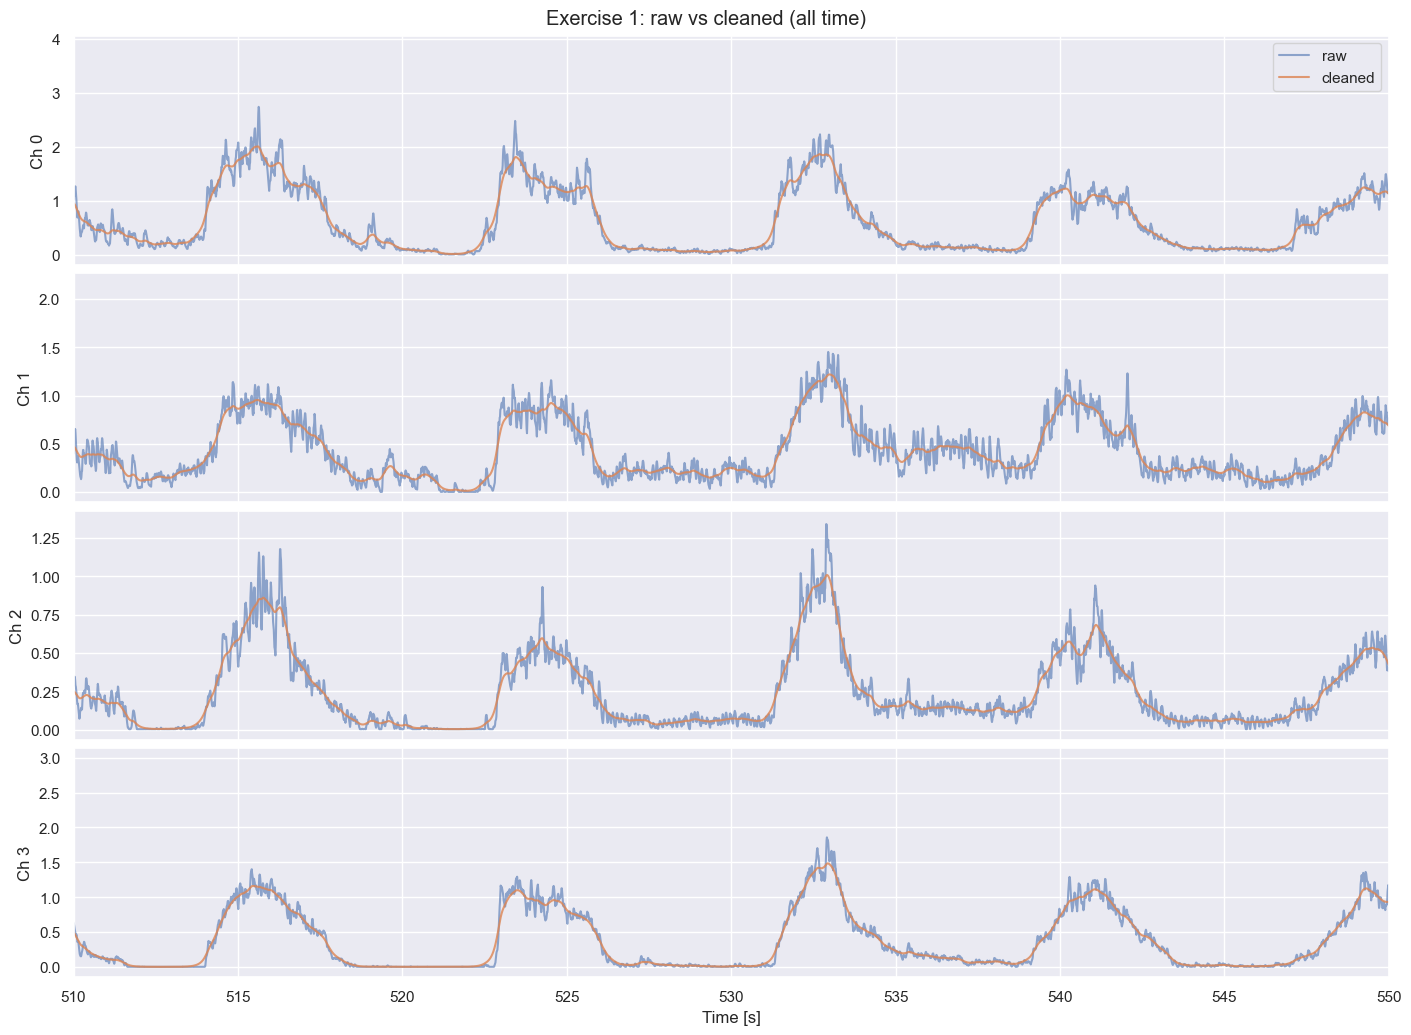

In [139]:
fig, axes = plt.subplots(channels_to_plot, 1, figsize=(14, 10), sharex=True, constrained_layout=True)
for i in range(channels_to_plot):
    axes[i].plot(t, emg_raw[:span, i], label='raw', alpha=0.6)
    axes[i].plot(t, emg_clean[:span, i], label='cleaned', alpha=0.8)  
    axes[i].set_xlim(510, 550)

    axes[i].set_ylabel(f'Ch {i}')
axes[-1].set_xlabel('Time [s]')
axes[0].legend()
fig.suptitle('Exercise 1: raw vs cleaned (all time)', y=1.02)
plt.show()

### Inspecting bad trials

In [140]:
def clean_and_filter_trials(processed_npz_path, output_dir='data/output'):
    processed_npz_path = Path(processed_npz_path)
    if not processed_npz_path.exists():
        print(f"Error: File not found at {processed_npz_path}")
        return None

    print(f"Filtering bad trials from {processed_npz_path}")

    data = np.load(processed_npz_path, allow_pickle=True)
    emg = data['emg']
    restimulus = data['restimulus']   
    rerepetition = data['rerepetition']
    fs = data['fs']
    
    DEAD_THRESHOLD = 1e-6    
    ARTIFACT_THRESHOLD = 5.0 

    bad_trials_indices = []    
    movements = np.unique(restimulus)
    movements = movements[movements != 0] # active movements only

    for mov in movements:
        for rep in range(1, 11): 
            mask_indices = np.where((restimulus == mov) & (rerepetition == rep))[0]
            
            if len(mask_indices) == 0:
                continue
            
            trial_data = emg[mask_indices]
            
            is_artifact = np.max(np.abs(trial_data)) > ARTIFACT_THRESHOLD
            
            channel_stds = np.std(trial_data, axis=0)
            is_dead_channel = np.any(channel_stds < DEAD_THRESHOLD)
            
            if is_dead_channel or is_artifact:
                reason = "Artifact" if is_artifact else "Dead Channel(s): "
                
                if is_dead_channel:
                    dead_ch_idx = np.where(channel_stds < DEAD_THRESHOLD)[0]
                    reason += f" {dead_ch_idx + 1}"
                
                print(f"  Discarding Bad Trial: Mov {mov}, Rep {rep} [{reason}]")
                bad_trials_indices.extend(mask_indices)

    keep_mask = (restimulus != 0)
    if len(bad_trials_indices) > 0:
        keep_mask[bad_trials_indices] = False

    emg_final = emg[keep_mask]
    restimulus_final = restimulus[keep_mask]
    rerepetition_final = rerepetition[keep_mask]

    print(f"Original shape: {emg.shape}")
    print(f"Final shape:    {emg_final.shape} (Rest & Bad Trials removed)")

    filename_parts = processed_npz_path.stem.split('_')
    subject_id = filename_parts[0]
    out_dir_full = Path(output_dir) / subject_id
    output_path = out_dir_full / f'{subject_id}_ex1_cleaned.npz'

    np.savez(output_path, 
             emg=emg_final, 
             restimulus=restimulus_final, 
             rerepetition=rerepetition_final, 
             fs=fs)

    print(f"Cleaned data saved to: {output_path}")
    print("-" * 30)
    return output_path

In [141]:
input_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_processed.npz'
clean_and_filter_trials(input_path, output_dir=EMG_OUTPUT_DIR)

Filtering bad trials from c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s2\s2_ex1_processed.npz
Original shape: (100686, 10)
Final shape:    (41791, 10) (Rest & Bad Trials removed)
Cleaned data saved to: c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s2\s2_ex1_cleaned.npz
------------------------------


WindowsPath('c:/Users/rokas/Documents/NX_NSSP_public/NX-421-project/output/emg/s2/s2_ex1_cleaned.npz')

### Visualizing average activation maps

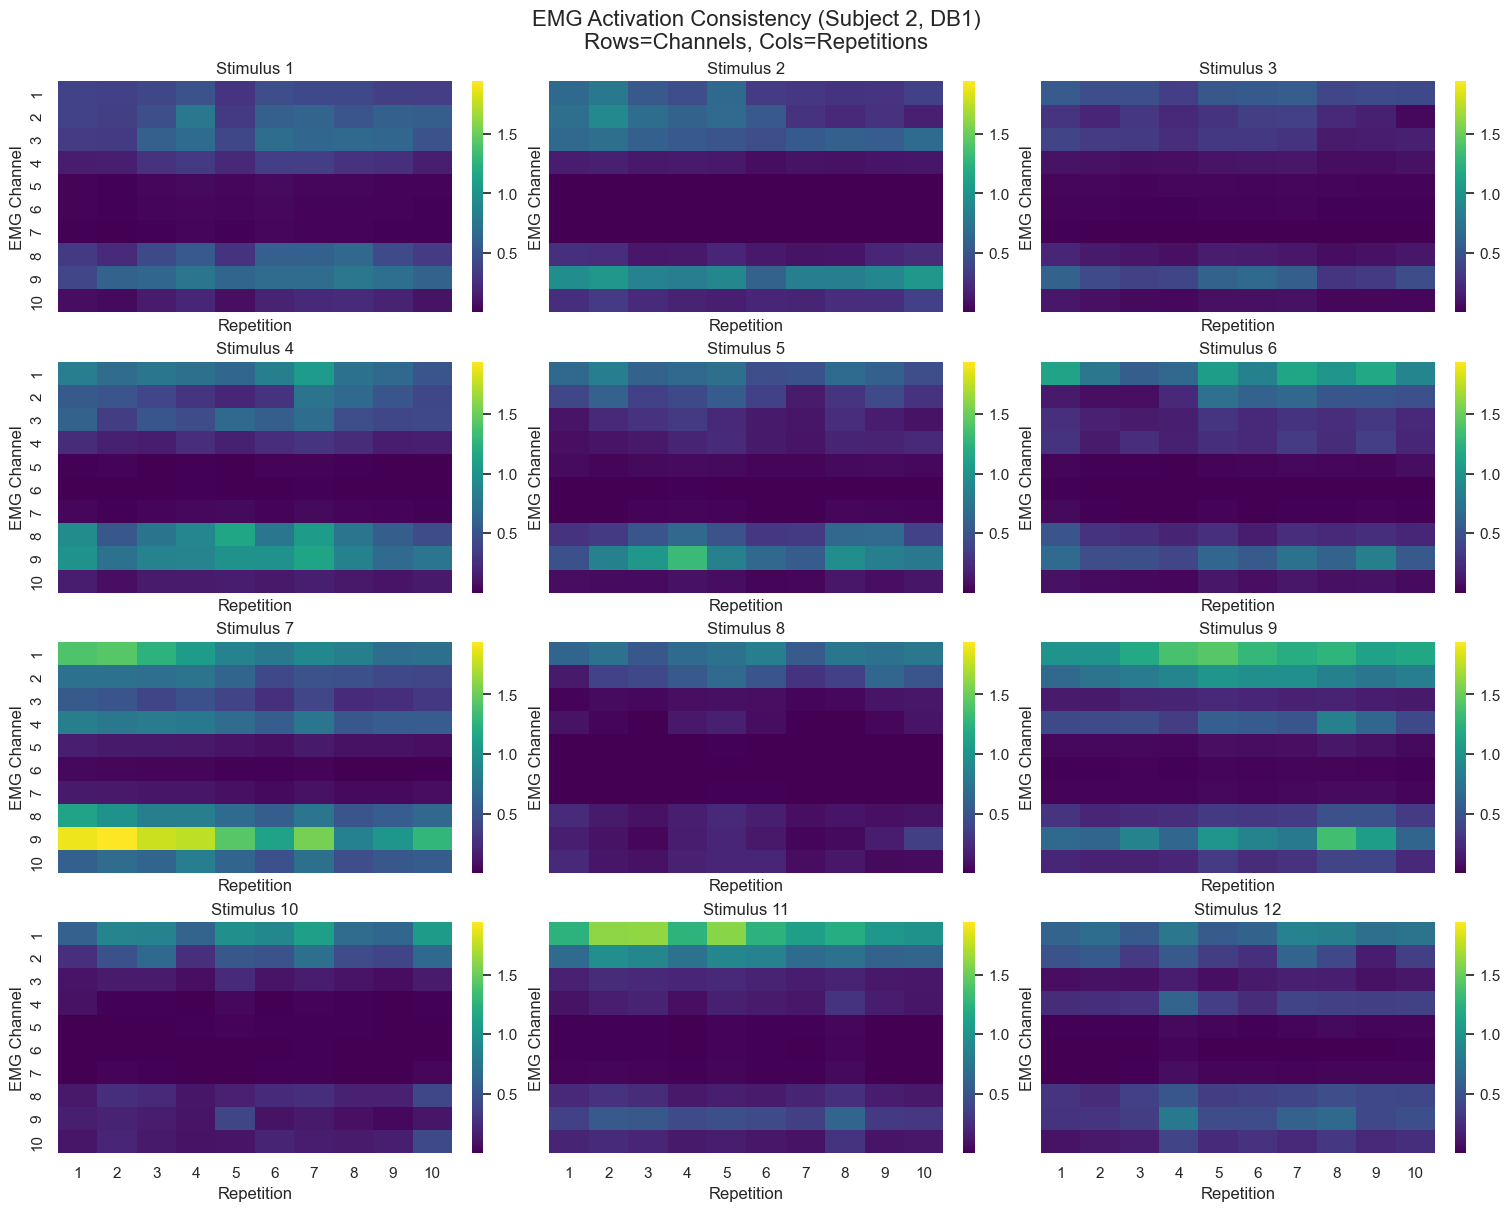

In [142]:
input_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_cleaned.npz'

data = np.load(input_path)
emg = data['emg']
stimulus = data['restimulus']
repetition = data['rerepetition']
fs = float(data['fs'])

unique_movs = np.unique(stimulus)
unique_reps = np.unique(repetition)

n_channels = emg.shape[1]
n_stimuli = len(unique_movs)
n_repetitions = len(unique_reps)

activation_matrix = np.full((n_channels, n_stimuli, n_repetitions), np.nan)

for mov_idx, mov_label in enumerate(unique_movs):
    for rep_idx, rep_label in enumerate(unique_reps):
        mask = (stimulus == mov_label) & (repetition == rep_label)
        trial_data = emg[mask]
        
        if len(trial_data) > 0:
            activation_matrix[:, mov_idx, rep_idx] = np.mean(trial_data, axis=0)

fig, ax = plt.subplots(4, 3, figsize=(15, 12), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

vmin = np.nanmin(activation_matrix)
vmax = np.nanmax(activation_matrix)

for stimuli_idx in range(n_stimuli):
    data_for_plot = activation_matrix[:, stimuli_idx, :]
    
    sns.heatmap(data_for_plot, ax=ax[stimuli_idx], 
                xticklabels=np.arange(1, 11), 
                yticklabels=np.arange(1, 11), 
                cbar=True, cmap="viridis", vmin=vmin, vmax=vmax)
    
    ax[stimuli_idx].set_title(f"Stimulus {unique_movs[stimuli_idx]}")
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG Channel")

plt.suptitle(f"EMG Activation Consistency (Subject 2, DB1)\nRows=Channels, Cols=Repetitions", fontsize=16)
plt.show()

## Preparing datasets (split)

### Inspecting dependence across repetitions in data
Paper suggests that  a significant (P < 0.05) dependence on the repetition is obtained in 25.93% (database 1). This result can be related to neuromuscular adaptation to the movement. Despite this, the effect seems to be significant only in a few subjects (especially considering sEMG); care should be taken when splitting movement repetitions for movement classification.

=> we inspect to see if this is the case for our patient (#2).

Regression Slope:   -0.002581
R-squared:          0.003487
P-value:            5.217542e-01

Conclusion: The relationship is NOT significant (p < 0.05).
Signal amplitude remains stable across repetitions (no significant adaptation observed).


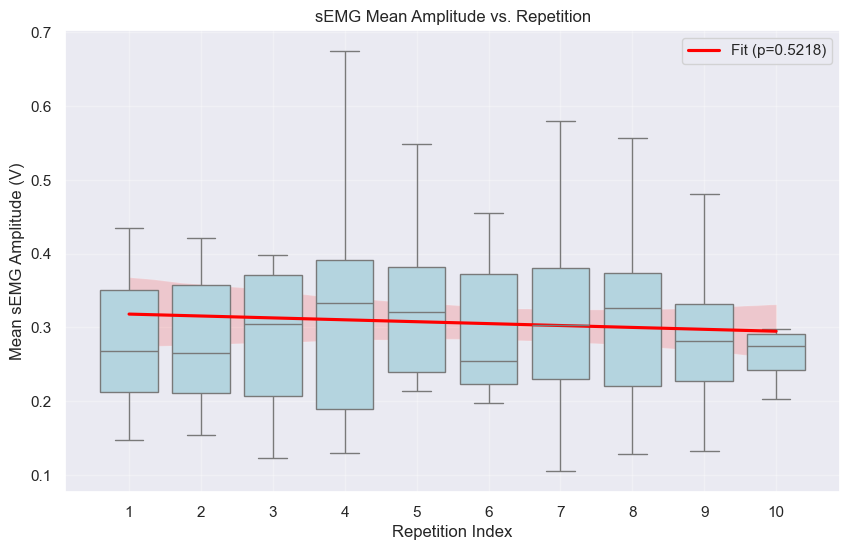

In [127]:
input_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_cleaned.npz'
data = np.load(input_path)
emg = data['emg']
restimulus = data['restimulus']
repetition = data['rerepetition']

trial_amplitudes = []
trial_reps = []

movements = np.unique(restimulus)
reps = np.unique(repetition)

for r in reps:
    for m in movements:
        mask = (restimulus == m) & (repetition == r)
        if np.any(mask):
            trial_data = emg[mask]
            mean_amp = np.mean(np.abs(trial_data))
            
            trial_amplitudes.append(mean_amp)
            trial_reps.append(r)

trial_amplitudes = np.array(trial_amplitudes)
trial_reps = np.array(trial_reps)

slope, intercept, r_value, p_value, std_err = linregress(trial_reps, trial_amplitudes)

print(f"Regression Slope:   {slope:.6f}")
print(f"R-squared:          {r_value**2:.6f}")
print(f"P-value:            {p_value:.6e}")

is_significant = p_value < 0.05
trend = "increasing" if slope > 0 else "decreasing"
print(f"\nConclusion: The relationship is {'SIGNIFICANT' if is_significant else 'NOT significant'} (p < 0.05).")
if is_significant:
    print(f"There is a statistically significant {trend} trend in signal amplitude over time.")
    print("This suggests neuromuscular adaptation or fatigue may be present.")
else:
    print("Signal amplitude remains stable across repetitions (no significant adaptation observed).")

plt.figure(figsize=(10, 6))
sns.boxplot(x=trial_reps, y=trial_amplitudes, color='lightblue', showfliers=False)
sns.regplot(x=trial_reps - 1, y=trial_amplitudes, scatter=False, color='red', 
            label=f'Fit (p={p_value:.4f})') # x - 1 because boxplot starts at 0 index

plt.title('sEMG Mean Amplitude vs. Repetition')
plt.xlabel('Repetition Index')
plt.ylabel('Mean sEMG Amplitude (V)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Splitting data

Although analysis from previous cell showed that there is not a significant dependence withint repetitions we will still split the data with specific repetitions, as recommended in paper.

We partitioned the data by repetition, designating Repetitions 1, 3, 4, 6, 8, and 9 for training, Repetitions 2 and 5 for validation, and Repetitions 7 and 10 for testing. This approach was chosen to mitigate data leakage inherent in random splitting of time-series windows and to account for the "neuromuscular adaptation" observed in the dataset, where signal amplitude can vary significantly between repetitions. 

In [143]:
def split_data_by_repetition(cleaned_npz_path, output_dir='data/output'):
    cleaned_npz_path = Path(cleaned_npz_path)
    if not cleaned_npz_path.exists():
        raise FileNotFoundError(f"{cleaned_npz_path} not found.")

    data = np.load(cleaned_npz_path, allow_pickle=True)
    X = data['emg']
    y = data['restimulus']
    rep = data['rerepetition']
    fs = float(data['fs'])

    train_reps = [1, 3, 4, 6, 8, 9]
    val_reps   = [2, 5]
    test_reps  = [7, 10]

    mask_train = np.isin(rep, train_reps)
    mask_val   = np.isin(rep, val_reps)
    mask_test  = np.isin(rep, test_reps)

    X_train, y_train, rep_train = X[mask_train], y[mask_train], rep[mask_train]
    X_val,   y_val,   rep_val   = X[mask_val],   y[mask_val],   rep[mask_val]
    X_test,  y_test,  rep_test  = X[mask_test],  y[mask_test],  rep[mask_test]

    print(f"Train samples: {len(X_train)} (Reps {train_reps})")
    print(f"Val samples:   {len(X_val)}   (Reps {val_reps})")
    print(f"Test samples:  {len(X_test)}  (Reps {test_reps})")

    filename_parts = cleaned_npz_path.stem.split('_')
    subject_id = filename_parts[0]
    out_dir_full = Path(output_dir) / subject_id
    splits_path = out_dir_full / f'{subject_id}_ex1_splits.npz'

    np.savez(
        splits_path,
        X_train=X_train, y_train=y_train, rep_train=rep_train,
        X_val=X_val,     y_val=y_val,     rep_val=rep_val,
        X_test=X_test,   y_test=y_test,   rep_test=rep_test,
        fs=fs
    )

    print(f"Saved splits to {splits_path}")
    return splits_path

In [144]:
input_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_cleaned.npz'
split_data_by_repetition(input_path, output_dir=EMG_OUTPUT_DIR)

Train samples: 24993 (Reps [1, 3, 4, 6, 8, 9])
Val samples:   8753   (Reps [2, 5])
Test samples:  8045  (Reps [7, 10])
Saved splits to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s2\s2_ex1_splits.npz


WindowsPath('c:/Users/rokas/Documents/NX_NSSP_public/NX-421-project/output/emg/s2/s2_ex1_splits.npz')

## Selecting features

In [128]:
split_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_splits.npz'
data = np.load(split_path)

X_train_raw, y_train_raw, rep_train_raw = data['X_train'], data['y_train'], data['rep_train']
X_val_raw,   y_val_raw,   rep_val_raw   = data['X_val'],   data['y_val'],   data['rep_val']
X_test_raw,  y_test_raw,  rep_test_raw  = data['X_test'],  data['y_test'],  data['rep_test']

print(f"raw data train points: {len(X_train_raw)}")

def get_features_from_trial(window):    
    # 1. Standard Features
    f_mav = np.mean(np.abs(window), axis=0)
    f_rms = np.sqrt(np.mean(window**2, axis=0))
    f_wl  = np.sum(np.abs(np.diff(window, axis=0)), axis=0)
    f_var = np.var(window, axis=0)
    f_max = np.max(window, axis=0)

    # 2. Additional Features (Boostani 2003, Sensors 2019)
    # Log Detector (LogD)
    f_logd = np.exp(np.mean(np.log(np.abs(window) + 1e-6), axis=0))
    
    # Histogram Stats (Skew/Kurtosis)
    f_skew = skew(window, axis=0)
    f_kurt = kurtosis(window, axis=0)
    
    # Stack: 10 features * 10 channels = 100 columns
    return np.concatenate([
        f_mav, f_rms, f_wl, f_var, f_max,  
        f_logd, f_skew, f_kurt 
    ])

def build_trial_dataset(X_data, y_data, rep_data):
    features_list = []
    labels_list = []
    
    unique_movs = np.unique(y_data)
    unique_reps = np.unique(rep_data)
    
    for mov in unique_movs:
        for rep in unique_reps:
            # Mask: Isolate ONE specific trial
            mask = (y_data == mov) & (rep_data == rep)
            trial_segment = X_data[mask]
            
            # Skip if empty (e.g. bad trial removed earlier)
            if len(trial_segment) == 0:
                continue
                
            # Collapse time dimension -> One Feature Vector
            feats = get_features_from_trial(trial_segment)
            
            features_list.append(feats)
            labels_list.append(mov)
            
    return np.array(features_list), np.array(labels_list)

X_train, y_train = build_trial_dataset(X_train_raw, y_train_raw, rep_train_raw)
X_val,   y_val   = build_trial_dataset(X_val_raw,   y_val_raw,   rep_val_raw)
X_test,  y_test  = build_trial_dataset(X_test_raw,  y_test_raw,  rep_test_raw)

print(f"\nFinal Dataset Shapes (Samples, Features):")
print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

raw data train points: 24993

Final Dataset Shapes (Samples, Features):
Train: (72, 80)
Val:   (24, 80)
Test:  (24, 80)


### Plotting features

We did not include all features / channels in our report for obvious reasons. Grader can play around with the parameters here to investigate the visualization of the features, as we did when we assessed them.

| Feature Index | Feature Name | Abbreviation |
|--------------|--------------|--------------|
| **0** | Mean Absolute Value | MAV |
| **1** | Root Mean Square | RMS |
| **2** | Waveform Length | WL |
| **3** | Variance | VAR |
| **4** | Maximum | MAX |
| **5** | Log Detector | LogD |
| **6** | Skewness | Skew |
| **7** | Kurtosis | Kurt |

In [129]:
FEATURE_NAMES = {
    0: "MAV",
    1: "RMS",
    2: "WL",
    3: "VAR",
    4: "MAX",
    5: "LogD",
    6: "Skew",
    7: "Kurt"
}

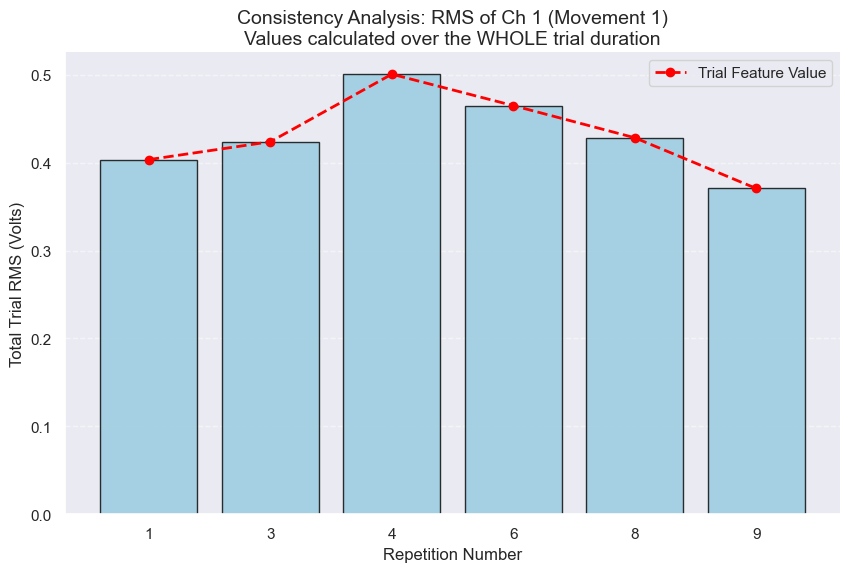

In [131]:
feature_idx = 1
target_mov = 1
feature_name = FEATURE_NAMES[feature_idx]
channel_idx = 0

plot_data = []

for rep_id in np.unique(rep_train_raw):
    mask = (y_train_raw == target_mov) & (rep_train_raw == rep_id)
    raw_segment = X_train_raw[mask]
    
    if len(raw_segment) > 0:
        feats = get_features_from_trial(raw_segment)
        
        col = (feature_idx * 10) + channel_idx
        val = feats[col]
        
        plot_data.append({
            'Repetition': str(int(rep_id)),
            'Feature Value': val
        })

df = pd.DataFrame(plot_data)

plt.figure(figsize=(10, 6))

sns.barplot(data=df, x='Repetition', y='Feature Value', 
            color='skyblue', edgecolor='black', alpha=0.8)

plt.plot(range(len(df)), df['Feature Value'], color='red', marker='o', 
         linestyle='--', linewidth=2, label='Trial Feature Value')

plt.title(f"Consistency Analysis: {feature_name} of Ch {channel_idx+1} (Movement {target_mov})\n"
          f"Values calculated over the WHOLE trial duration", fontsize=14)
plt.ylabel(f"Total Trial {feature_name} (Volts)", fontsize=12)
plt.xlabel("Repetition Number", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()

plt.show()

#### Plotting all features for one movement

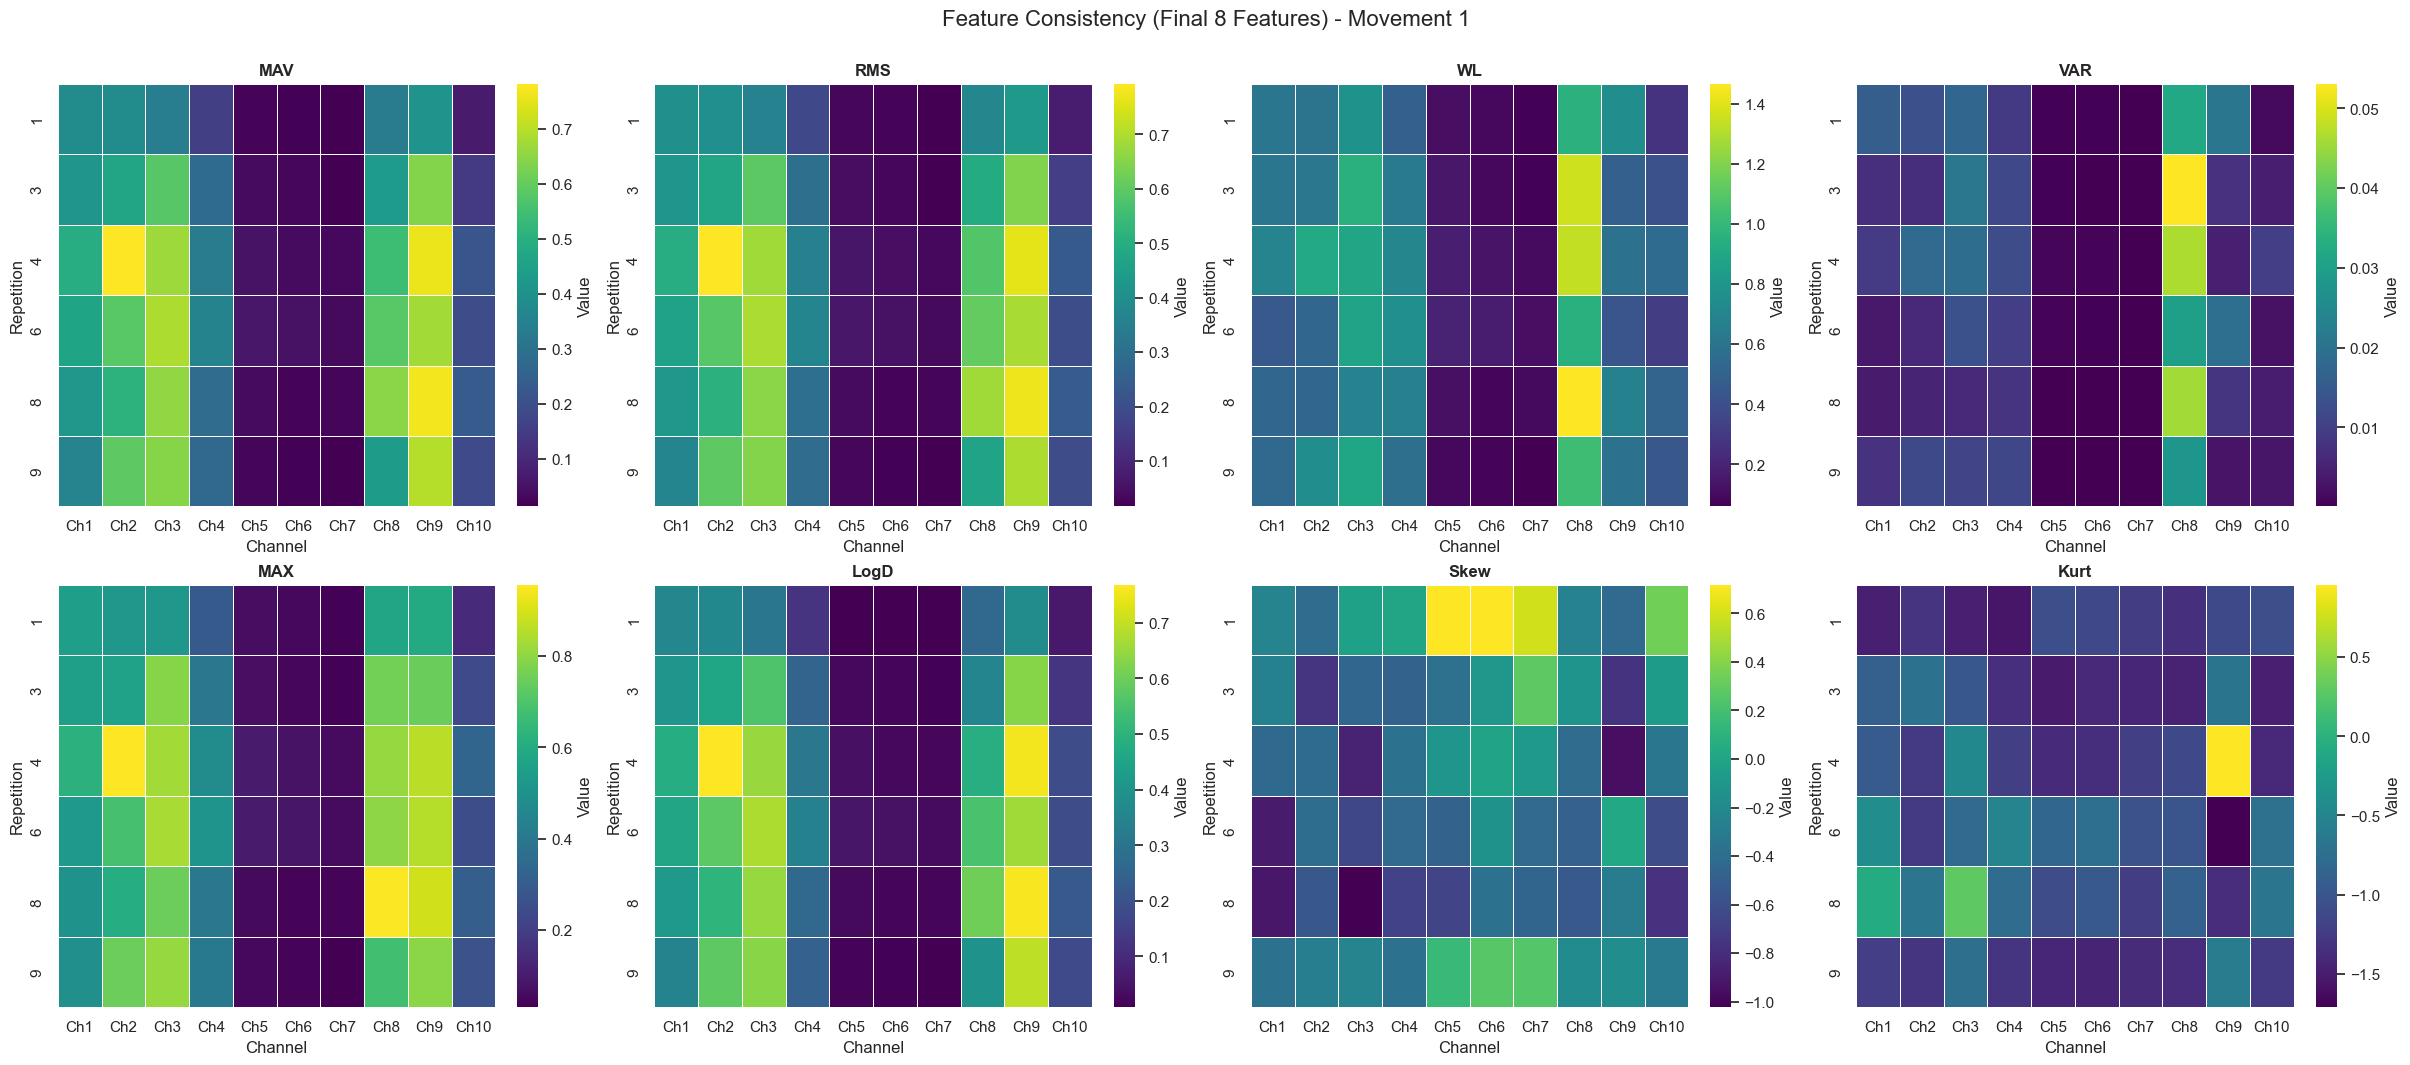

In [132]:
target_mov = 1
reps = np.unique(rep_train_raw)

trial_feats_map = {} 
for r in reps:
    mask = (y_train_raw == target_mov) & (rep_train_raw == r)
    raw_segment = X_train_raw[mask]
    if len(raw_segment) > 0:
        trial_feats_map[r] = get_features_from_trial(raw_segment)

fig, axes = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    feature_name = FEATURE_NAMES[i]
    
    heatmap_rows = []
    for r in reps:
        if r in trial_feats_map:
            all_feats = trial_feats_map[r]
            
            start = i * 10
            end = start + 10
            vals = all_feats[start:end]
            
            row_dict = {'Rep': int(r)}
            for ch in range(10):
                row_dict[f'Ch{ch+1}'] = vals[ch]
            heatmap_rows.append(row_dict)
            
    df_heat = pd.DataFrame(heatmap_rows).set_index('Rep')
    
    # Plot Heatmap
    sns.heatmap(df_heat, annot=False, cmap="viridis", linewidths=.5, ax=ax,
                cbar_kws={'label': 'Value'})
    
    ax.set_title(f"{feature_name}", fontsize=12, fontweight='bold')
    ax.set_ylabel("Repetition")
    ax.set_xlabel("Channel")

fig.suptitle(f"Feature Consistency (Final 8 Features) - Movement {target_mov}", fontsize=16, y=1.05)
plt.show()

## Support Vector Machine
Instead of standard k-fold cross-validation, which would randomly shuffle trials and potentially cause data leakage or mix repetitions, we used PredefinedSplit to force the grid search to train exclusively on the designated Training Set (Reps 1, 3, 4, 6, 8, 9) and evaluate on the Validation Set (Reps 2, 5).

Starting SVM Grid Search on 96 samples...
Fitting 1 folds for each of 24 candidates, totalling 24 fits
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Validation Accuracy: 87.50%

FINAL TEST ACCURACY: 95.83%
              precision    recall  f1-score   support

       Mov 1       1.00      1.00      1.00         2
       Mov 2       1.00      1.00      1.00         2
       Mov 3       1.00      1.00      1.00         2
       Mov 4       1.00      1.00      1.00         2
       Mov 5       1.00      1.00      1.00         2
       Mov 6       1.00      1.00      1.00         2
       Mov 7       1.00      1.00      1.00         2
       Mov 8       1.00      1.00      1.00         2
       Mov 9       1.00      1.00      1.00         2
      Mov 10       1.00      0.50      0.67         2
      Mov 11       0.67      1.00      0.80         2
      Mov 12       1.00      1.00      1.00         2

    accuracy                           0.96        24
   macro av

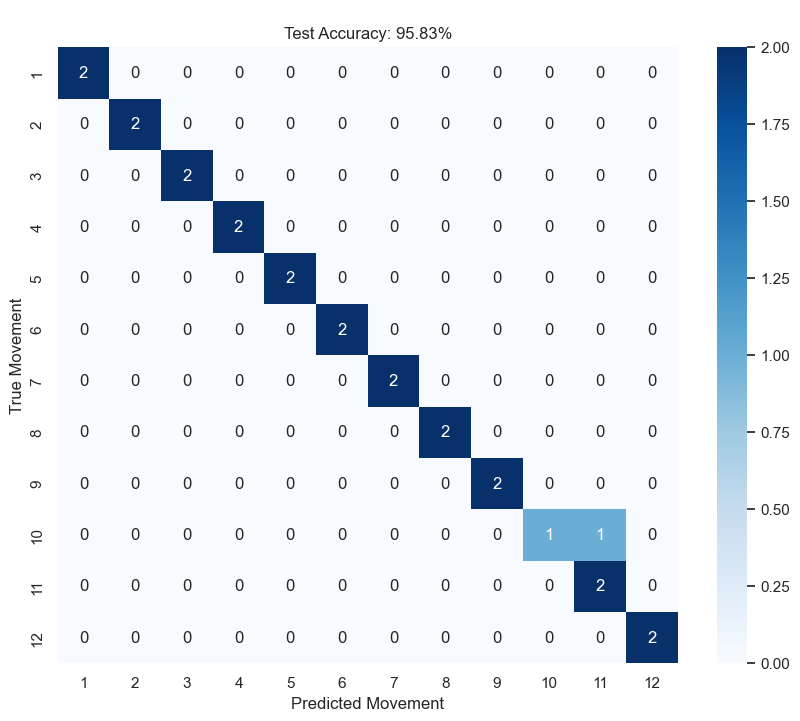

In [133]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

X_combined = np.vstack((X_train_scaled, X_val_scaled))
y_combined = np.hstack((y_train, y_val))

test_fold = np.concatenate([
    np.full(X_train_scaled.shape[0], -1),
    np.full(X_val_scaled.shape[0], 0)
])
ps = PredefinedSplit(test_fold)

param_grid = {
    'C': [0.1, 1, 10, 100], 
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

print(f"Starting SVM Grid Search on {len(y_combined)} samples...")
grid = GridSearchCV(
    SVC(), 
    param_grid, 
    cv=ps,
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1
)

grid.fit(X_combined, y_combined)

print(f"Best Parameters: {grid.best_params_}")
print(f"Best Validation Accuracy: {grid.best_score_:.2%}")

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"\nFINAL TEST ACCURACY: {acc:.2%}")
class_names = [f"Mov {i}" for i in np.unique(y_test)]
print(classification_report(y_test, y_pred, target_names=class_names))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title(f"\nTest Accuracy: {acc:.2%}")
plt.xlabel("Predicted Movement")
plt.ylabel("True Movement")
plt.show()


## Feature reduction

### Recursive Feature Elimination

In [134]:
features_to_select = 11

print(f"Baseline Data Shape: {X_train.shape} (Features: {X_train.shape[1]})")

test_fold = np.concatenate([
    np.full(X_train.shape[0], -1),
    np.full(X_val.shape[0], 0)
])
ps = PredefinedSplit(test_fold)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

X_combined = np.vstack((X_train_s, X_val_s))
y_combined = np.hstack((y_train, y_val))

estimator = SVC(kernel="linear")
selector = RFE(estimator, n_features_to_select=features_to_select, step=2)
selector = selector.fit(X_train_s, y_train)

X_train_rfe = selector.transform(X_train_s)
X_val_rfe   = selector.transform(X_val_s)
X_test_rfe  = selector.transform(X_test_s)
X_combined_rfe = np.vstack((X_train_rfe, X_val_rfe))

param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': ['scale', 0.01, 0.001], 'kernel': ['rbf', 'linear']}
grid_rfe = GridSearchCV(SVC(), param_grid, cv=ps, scoring='accuracy', n_jobs=-1)
grid_rfe.fit(X_combined_rfe, y_combined)

y_pred_rfe = grid_rfe.predict(X_test_rfe)
acc_rfe = accuracy_score(y_test, y_pred_rfe)
print(f"RFE Test Accuracy: {acc_rfe:.2%} (Using top {features_to_select} features)")
print(classification_report(y_test, y_pred_rfe))

Baseline Data Shape: (72, 80) (Features: 80)
RFE Test Accuracy: 91.67% (Using top 11 features)
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       0.67      1.00      0.80         2
           9       1.00      1.00      1.00         2
          10       1.00      0.50      0.67         2
          11       0.50      0.50      0.50         2
          12       1.00      1.00      1.00         2

    accuracy                           0.92        24
   macro avg       0.93      0.92      0.91        24
weighted avg       0.93      0.92      0.91        24



#### Looping over all number of features to select

In [135]:
accuracies = []
features_used = []
features_range = range(1, X_train.shape[1] + 1)

for n_features in features_range:
    estimator = SVC(kernel="linear")
    selector = RFE(estimator, n_features_to_select=n_features, step=2)
    selector = selector.fit(X_train_s, y_train)

    X_train_rfe = selector.transform(X_train_s)
    X_val_rfe   = selector.transform(X_val_s)
    X_test_rfe  = selector.transform(X_test_s)
    X_combined_rfe = np.vstack((X_train_rfe, X_val_rfe))

    grid_rfe = GridSearchCV(SVC(), param_grid, cv=ps, scoring='accuracy', n_jobs=-1)
    grid_rfe.fit(X_combined_rfe, y_combined)
    y_pred_rfe = grid_rfe.predict(X_test_rfe)
    acc_rfe = accuracy_score(y_test, y_pred_rfe)
    accuracies.append(acc_rfe)
    features_used.append(n_features)

best_acc = max(accuracies)
best_indices = [i for i, acc in enumerate(accuracies) if acc == best_acc]
best_n_features = min(features_used[i] for i in best_indices)
print(f"Best RFE Test Accuracy: {best_acc:.2%} (Using as few as {best_n_features} feature(s))")


Best RFE Test Accuracy: 95.83% (Using as few as 13 feature(s))


### Linear Discriminant Analysis (LDA)

In [136]:
lda = LDA()
X_train_lda = lda.fit_transform(X_train_s, y_train)
X_val_lda   = lda.transform(X_val_s)
X_test_lda  = lda.transform(X_test_s)
X_combined_lda = np.vstack((X_train_lda, X_val_lda))

print(f"LDA Input Features:  {X_train_s.shape[1]}")
print(f"LDA Output Components: {X_train_lda.shape[1]}")

grid_lda = GridSearchCV(SVC(), param_grid, cv=ps, scoring='accuracy', n_jobs=-1)
grid_lda.fit(X_combined_lda, y_combined)

y_pred_lda = grid_lda.predict(X_test_lda)
acc_lda = accuracy_score(y_test, y_pred_lda)
print(f"LDA Test Accuracy: {acc_lda:.2%} (Using 11 LDA components)")
print(classification_report(y_test, y_pred_lda))

LDA Input Features:  80
LDA Output Components: 11
LDA Test Accuracy: 79.17% (Using 11 LDA components)
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         2
           3       1.00      0.50      0.67         2
           4       0.67      1.00      0.80         2
           5       1.00      1.00      1.00         2
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         2
           8       0.50      0.50      0.50         2
           9       1.00      1.00      1.00         2
          10       0.50      0.50      0.50         2
          11       0.50      0.50      0.50         2
          12       1.00      1.00      1.00         2

    accuracy                           0.79        24
   macro avg       0.82      0.79      0.79        24
weighted avg       0.82      0.79      0.79        24



C:\Users\rokas\AppData\Local\Temp\ipykernel_21648\2769755941.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=scores, palette="viridis", edgecolor='black')


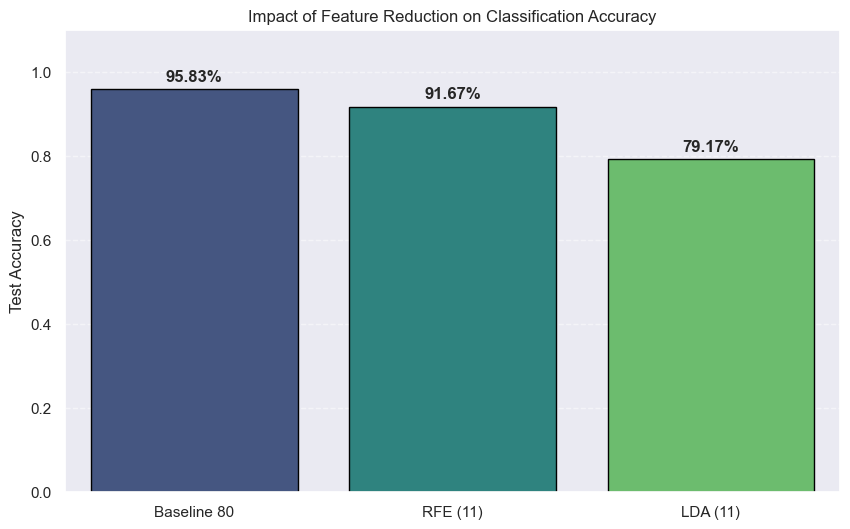

In [ ]:
methods = [f'Baseline {X_train.shape[1]}', f'RFE ({X_train_rfe.shape[1]})', f'LDA ({X_train_lda.shape[1]})']
scores = [0.9583, acc_rfe, acc_lda]

plt.figure(figsize=(10, 6))
sns.barplot(x=methods, y=scores, palette="viridis", edgecolor='black')

plt.ylim(0.0, 1.1) 

plt.title("Impact of Feature Reduction on Classification Accuracy")
plt.ylabel("Test Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.5)

for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontweight='bold', fontsize=12)

plt.show()

# Part 2: Generalization across subjects

## Load data

In [151]:
for i in range(1,28):
    subject_id = 's' + str(i)
    load_and_save_raw_data(subject_id=subject_id, base_dir=EMG_DIR, output_dir=EMG_DIR)

Loading raw file: S1_A1_E1.mat
Saved raw data to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s1\s1_ex1_raw.npz
Loading raw file: S2_A1_E1.mat
Saved raw data to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s2\s2_ex1_raw.npz
Loading raw file: S3_A1_E1.mat
Saved raw data to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s3\s3_ex1_raw.npz
Loading raw file: S4_A1_E1.mat
Saved raw data to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s4\s4_ex1_raw.npz
Loading raw file: S5_A1_E1.mat
Saved raw data to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s5\s5_ex1_raw.npz
Loading raw file: S6_A1_E1.mat
Saved raw data to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s6\s6_ex1_raw.npz
Loading raw file: S7_A1_E1.mat
Saved raw data to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\data\EMG\s7\s7_ex1_raw.npz
Loading raw file: S8_A1_E1.mat
Saved raw data to c:\Users\rokas\Documents\NX_NSSP_p

## Preprocessing data

### Low-pass filter at 1Hz to smooth the envelope

From paper: "Before performing the classification, the data from database 1 were preprocessed using a 1st order Butterworth low-pass filter with a 1 Hz cutoff frequency"

In [152]:
for i in range(1, 28):
    s_num_lowercase = 's' + str(i)
    s_a1_e1_path = Path(EMG_DIR) / s_num_lowercase / (s_num_lowercase + '_ex1_raw.npz')
    output_path = Path(EMG_OUTPUT_DIR) / s_num_lowercase / (s_num_lowercase + '_ex1_processed.npz')
    os.makedirs(Path(EMG_OUTPUT_DIR) / s_num_lowercase, exist_ok=True)
    
    output_path = preprocess_emg_data(
        raw_npz_path=s_a1_e1_path,
        output_dir=EMG_OUTPUT_DIR,
    )
    
    print(f'Processed data saved to {output_path}')

Processed (Filtered) data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s1\s1_ex1_processed.npz
Processed data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s1\s1_ex1_processed.npz
Processed (Filtered) data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s2\s2_ex1_processed.npz
Processed data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s2\s2_ex1_processed.npz
Processed (Filtered) data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s3\s3_ex1_processed.npz
Processed data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s3\s3_ex1_processed.npz
Processed (Filtered) data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s4\s4_ex1_processed.npz
Processed data saved to c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s4\s4_ex1_processed.npz
Processed (Filtered) data saved to c:\Users\

### Clean bad trials

In [153]:
for i in range(1,28):
    s_num_lowercase = 's' + str(i)
    input_path = Path(EMG_OUTPUT_DIR) /  s_num_lowercase / (s_num_lowercase + '_ex1_processed.npz')
    clean_and_filter_trials(input_path, output_dir=EMG_OUTPUT_DIR)

Filtering bad trials from c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s1\s1_ex1_processed.npz
  Discarding Bad Trial: Mov 2, Rep 4 [Dead Channel(s):  [6]]
  Discarding Bad Trial: Mov 2, Rep 9 [Dead Channel(s):  [6]]
  Discarding Bad Trial: Mov 11, Rep 2 [Dead Channel(s):  [6]]
  Discarding Bad Trial: Mov 11, Rep 9 [Dead Channel(s):  [6]]
  Discarding Bad Trial: Mov 12, Rep 4 [Dead Channel(s):  [6]]
  Discarding Bad Trial: Mov 12, Rep 5 [Dead Channel(s):  [2]]
  Discarding Bad Trial: Mov 12, Rep 7 [Dead Channel(s):  [4]]
  Discarding Bad Trial: Mov 12, Rep 9 [Dead Channel(s):  [4]]
Original shape: (101014, 10)
Final shape:    (35540, 10) (Rest & Bad Trials removed)
Cleaned data saved to: c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s1\s1_ex1_cleaned.npz
------------------------------
Filtering bad trials from c:\Users\rokas\Documents\NX_NSSP_public\NX-421-project\output\emg\s2\s2_ex1_processed.npz
Original shape: (100686, 10)
Final shape:    (4

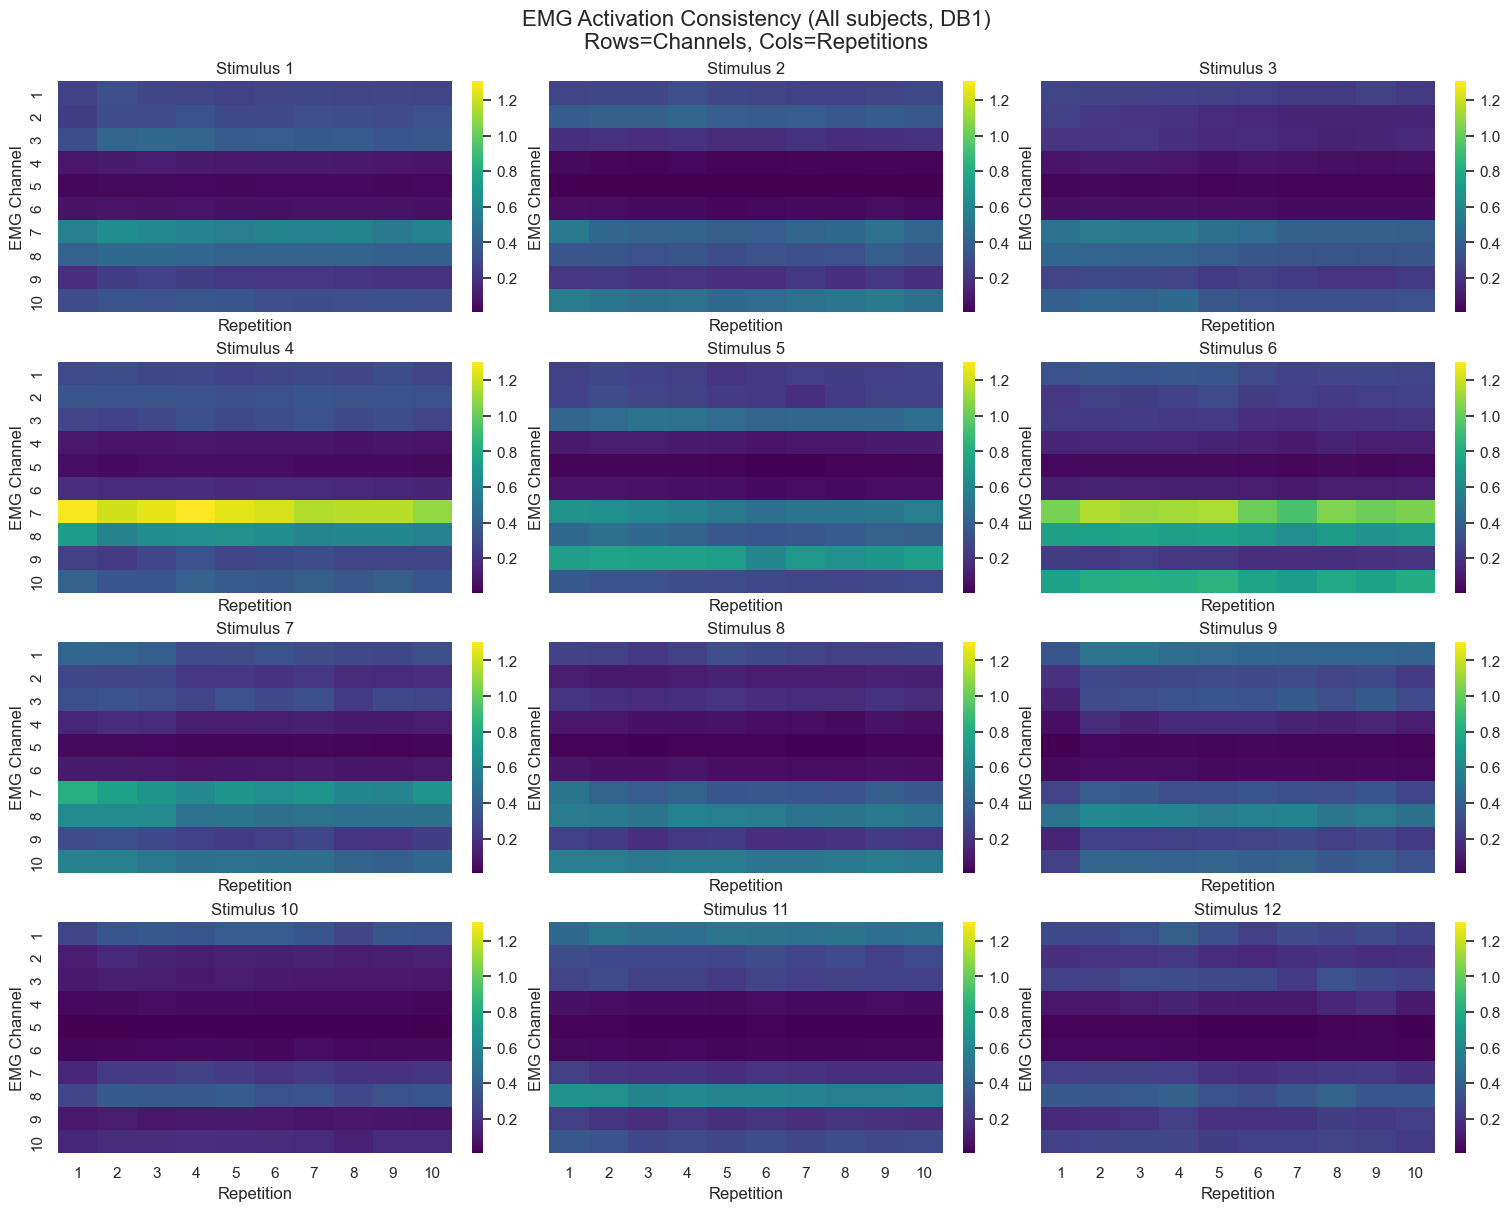

In [154]:
### Visualizing average activation maps
dataset = []
for subject in range(1,28):
    s_num_lowercase = 's' + str(subject)
    
    input_path = Path(EMG_OUTPUT_DIR) / s_num_lowercase / (s_num_lowercase + '_ex1_cleaned.npz')
    
    data = np.load(input_path)
    emg = data['emg']
    stimulus = data['restimulus']
    repetition = data['rerepetition']
    fs = float(data['fs'])
    
    unique_movs = np.unique(stimulus)
    unique_reps = np.unique(repetition)
    
    n_channels = emg.shape[1]
    n_stimuli = len(unique_movs)
    n_repetitions = len(unique_reps)
    
    activation_matrix = np.full((n_channels, n_stimuli, n_repetitions), np.nan)
    
    for mov_idx, mov_label in enumerate(unique_movs):
        for rep_idx, rep_label in enumerate(unique_reps):
            mask = (stimulus == mov_label) & (repetition == rep_label)
            trial_data = emg[mask]
            
            if len(trial_data) > 0:
                activation_matrix[:, mov_idx, rep_idx] = np.mean(trial_data, axis=0)
    
    dataset.append(activation_matrix)

avg = np.nanmean(np.stack(dataset, axis=0), axis=0)

fig, ax = plt.subplots(4, 3, figsize=(15, 12), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

vmin = np.nanmin(avg)
vmax = np.nanmax(avg)

for stimuli_idx in range(n_stimuli):
    data_for_plot = avg[:, stimuli_idx, :]
    
    sns.heatmap(data_for_plot, ax=ax[stimuli_idx], 
                xticklabels=np.arange(1, 11), 
                yticklabels=np.arange(1, 11), 
                cbar=True, cmap="viridis", vmin=vmin, vmax=vmax)
    
    ax[stimuli_idx].set_title(f"Stimulus {unique_movs[stimuli_idx]}")
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG Channel")

plt.suptitle(f"EMG Activation Consistency (All subjects, DB1)\nRows=Channels, Cols=Repetitions", fontsize=16)
plt.show()

## Extract features

In [155]:
target_mov = 6           # Movement to analyze (e.g., 1 = Index Flexion)
feature_idx = 1          # 1 = RMS
feature_name = "RMS"
channel_idx = 10
all_subjects_data = []

print(f"Aggregating {feature_name} data for Movement {target_mov} across subjects...")

for i in range(1, 28):
    s_id = f's{i}'
    file_path = Path(EMG_OUTPUT_DIR) / s_id / f'{s_id}_ex1_cleaned.npz'
    
    if not file_path.exists():
        print(f"Skipping {s_id} because file doesn't exist")
        continue
        
    data = np.load(file_path, allow_pickle=True)
    X = data['emg']
    y = data['restimulus']
    rep = data['rerepetition']
    
    mask_mov = (y == target_mov)    
    available_reps = np.unique(rep[mask_mov])
    
    for r in available_reps:
        mask_trial = (y == target_mov) & (rep == r)
        trial_data = X[mask_trial]
        
        if len(trial_data) > 0:
            feats = get_features_from_trial(trial_data) # all features
            
            col_idx = (feature_idx * 10) + channel_idx
            val = feats[col_idx]
            
            all_subjects_data.append({
                'Subject': i,
                'Repetition': r,
                'Feature Value': val
            })

df_all = pd.DataFrame(all_subjects_data)
print(f"Loaded {len(df_all)} trials from {df_all['Subject'].nunique()} subjects.")

Aggregating RMS data for Movement 6 across subjects...
Loaded 270 trials from 27 subjects.


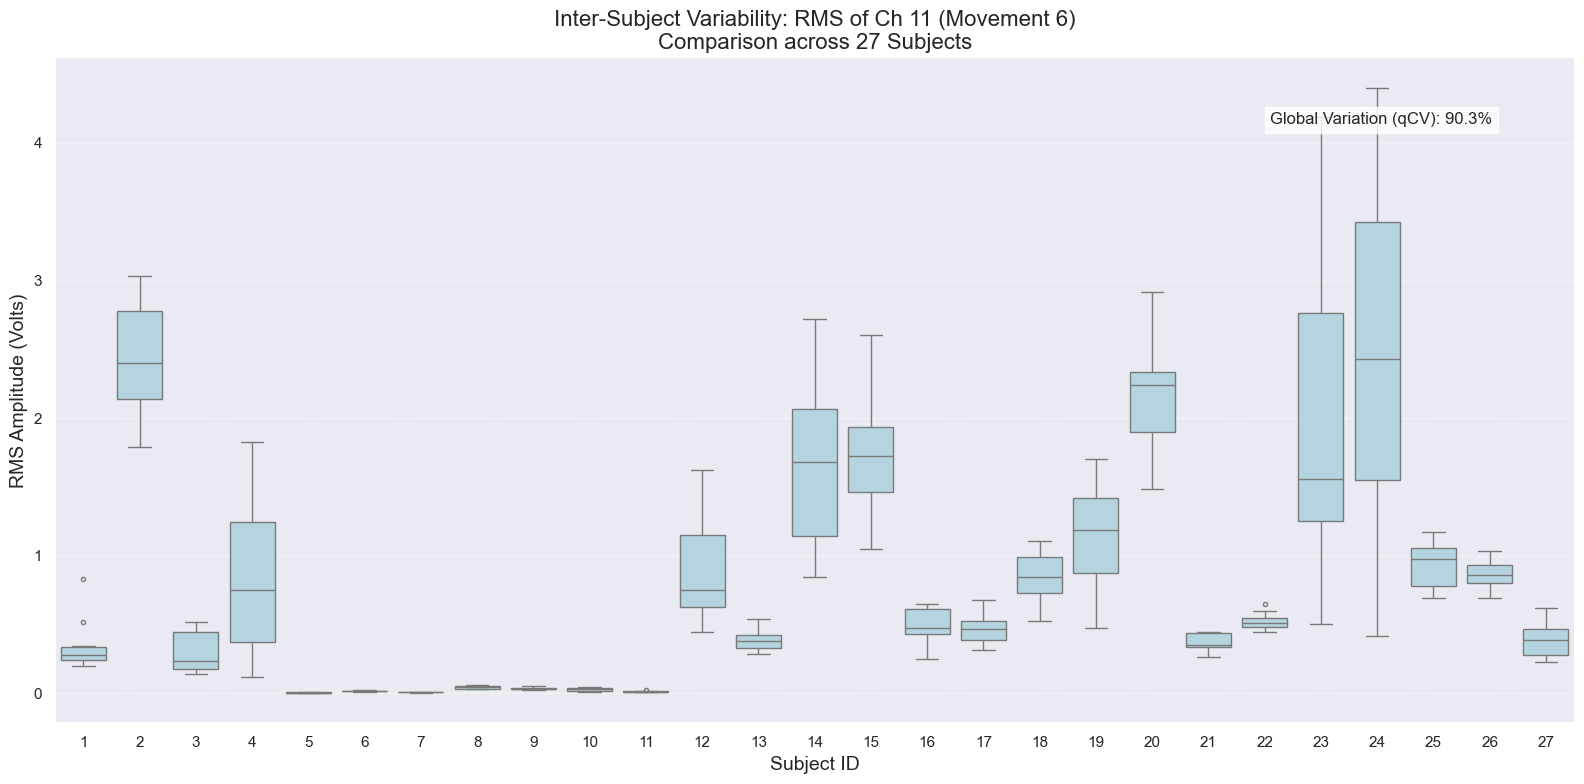

In [156]:
plt.figure(figsize=(16, 8))

sns.boxplot(
    data=df_all,
    x="Subject",
    y="Feature Value",
    color="lightblue",
    fliersize=3,
    linewidth=1,
)

plt.title(
    f"Inter-Subject Variability: {feature_name} of Ch {channel_idx+1} (Movement {target_mov})\n"
    f"Comparison across {df_all['Subject'].nunique()} Subjects",
    fontsize=16,
)
plt.ylabel(f"{feature_name} Amplitude (Volts)", fontsize=14)
plt.xlabel("Subject ID", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# ----------------------------
# Quantile Coefficient of Variation (qCV)
# ----------------------------
x = df_all["Feature Value"].to_numpy()
x = x[np.isfinite(x)]

q25, q75 = np.percentile(x, [25, 75])
denom = q75 + q25

if np.isclose(denom, 0.0):
    qcv_pct = np.nan
else:
    qcv_pct = 100.0 * (q75 - q25) / denom

plt.text(
    0.8,
    0.9,
    f"Global Variation (qCV): {qcv_pct:.1f}%",
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.8),
)

sns.despine()
plt.tight_layout()
plt.show()


Rows: 254160 Subjects: 27


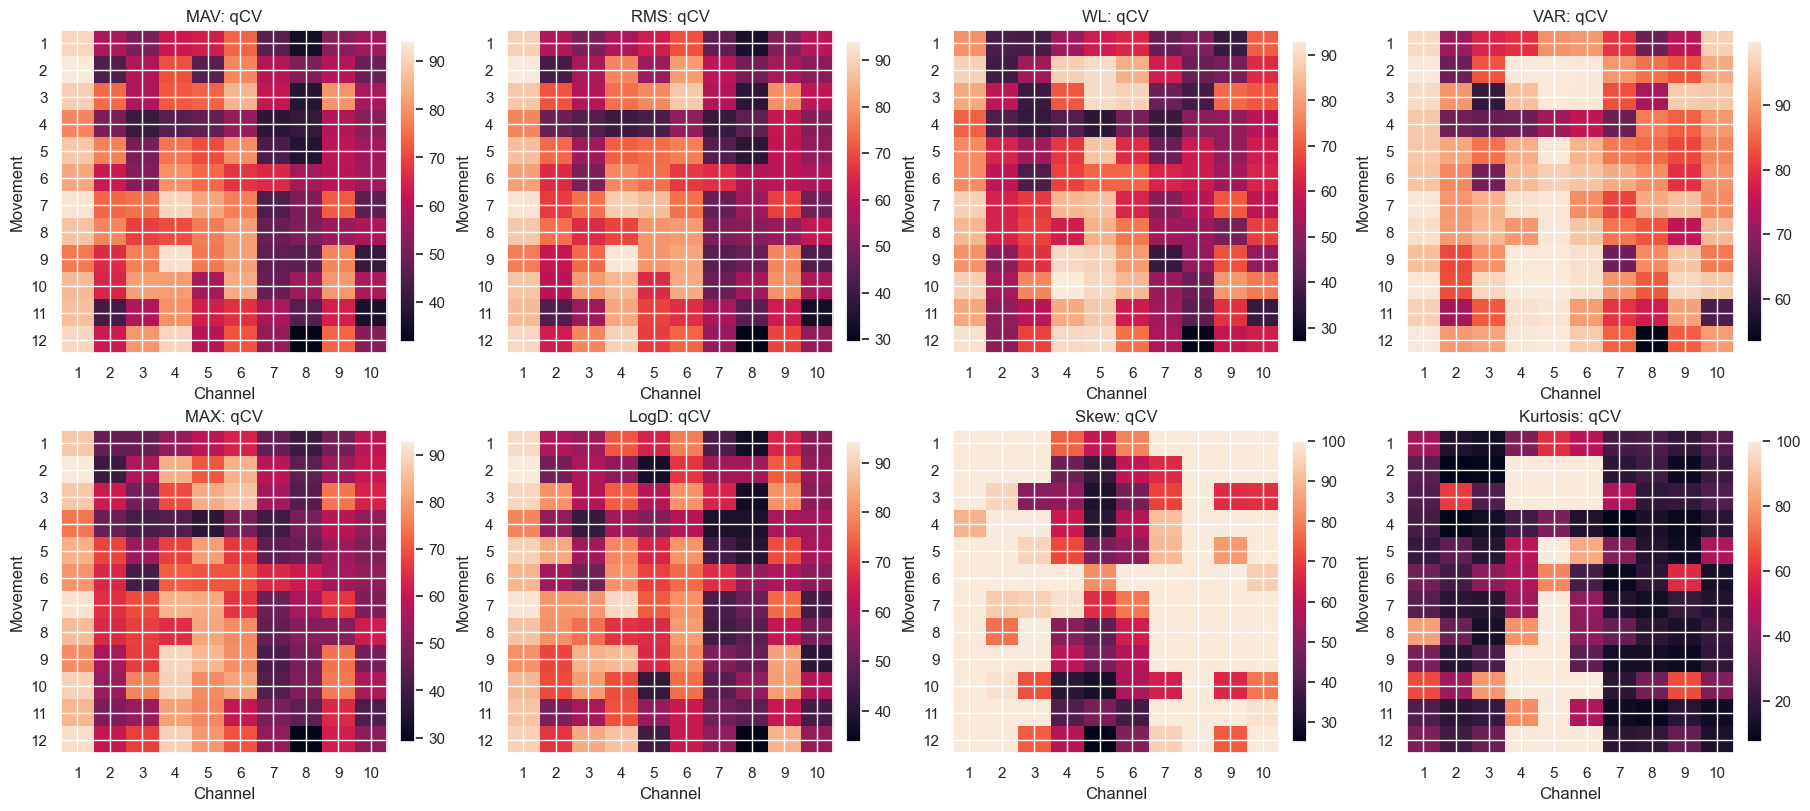

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# SETTINGS: choose what to sweep
# ----------------------------
MOVEMENTS = list(range(1, 13))          # adapt to your dataset (e.g., 1..12)
FEATURE_NAMES = [
    "MAV", "RMS", "WL", "VAR", "MAX",
    "LogD", "Skew", "Kurtosis"
]
FEATURE_IDXS = list(range(len(FEATURE_NAMES)))  # 0..7

CHANNEL_IDXS = list(range(0, 10))       # 0-based channels (adapt)

# Dispersion choice: "CV" | "rCV_MAD" | "IQR_over_median" | "qcv"
DISP_METRIC = "qcv"  # must match the branch string below

# qCV safety settings
QCV_DENOM_MODE = "abs_sum"   # "abs_sum" (recommended) | "signed_sum" (original)
QCV_EPS = 1e-12              # denom floor to avoid blow-ups

records = []

for i in range(1, 28):
    s_id = f"s{i}"
    file_path = Path(EMG_OUTPUT_DIR) / s_id / f"{s_id}_ex1_cleaned.npz"
    if not file_path.exists():
        continue

    data = np.load(file_path, allow_pickle=True)
    X = data["emg"]
    y = data["restimulus"]
    rep = data["rerepetition"]

    n_channels = X.shape[1]

    for mov in MOVEMENTS:
        mask_mov = (y == mov)
        if not np.any(mask_mov):
            continue

        reps_here = np.unique(rep[mask_mov])
        for r in reps_here:
            mask_trial = mask_mov & (rep == r)
            trial_data = X[mask_trial]
            if trial_data.shape[0] == 0:
                continue

            feats = get_features_from_trial(trial_data)  # 1D: (n_features * n_channels,)

            for f_idx in FEATURE_IDXS:
                for ch_idx in CHANNEL_IDXS:
                    col_idx = f_idx * n_channels + ch_idx
                    if col_idx >= len(feats):
                        continue

                    records.append({
                        "Subject": i,
                        "Movement": mov,
                        "Repetition": int(r),
                        "FeatureIdx": f_idx,
                        "Feature": (FEATURE_NAMES[f_idx] if FEATURE_NAMES else f"F{f_idx}"),
                        "ChannelIdx": ch_idx,
                        "Channel": ch_idx + 1,
                        "Value": float(feats[col_idx]),
                    })

df = pd.DataFrame(records)
print("Rows:", len(df), "Subjects:", df["Subject"].nunique())

# ----------------------------
# Collapse reps per subject: one value per subject
# ----------------------------
subj_level = (
    df.groupby(["Feature", "FeatureIdx", "Movement", "ChannelIdx", "Channel", "Subject"])["Value"]
      .median()
      .reset_index(name="SubjAgg")
)

def _dispersion(series):
    x = np.asarray(series, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan

    mean = float(np.mean(x))
    std = float(np.std(x, ddof=1)) if x.size > 1 else 0.0

    med = float(np.median(x))
    q25, q75 = np.percentile(x, [25, 75])
    iqr = float(q75 - q25)
    mad = float(np.median(np.abs(x - med)))

    if DISP_METRIC == "CV":
        if np.isclose(mean, 0.0):
            return np.nan
        return 100.0 * std / np.abs(mean)

    if DISP_METRIC == "rCV_MAD":
        if np.isclose(med, 0.0):
            return np.nan
        robust_sigma = 1.4826 * mad
        return 100.0 * robust_sigma / np.abs(med)

    if DISP_METRIC == "IQR_over_median":
        if np.isclose(med, 0.0):
            return np.nan
        return 100.0 * iqr / np.abs(med)

    if DISP_METRIC == "qcv":
        # Original qCV uses denom = (q75 + q25), which breaks on signed/near-zero data.
        if QCV_DENOM_MODE == "abs_sum":
            denom = float(np.abs(q75) + np.abs(q25))
        elif QCV_DENOM_MODE == "signed_sum":
            denom = float(q75 + q25)
        else:
            raise ValueError(f"Unknown QCV_DENOM_MODE: {QCV_DENOM_MODE}")

        if not np.isfinite(denom) or np.abs(denom) < QCV_EPS:
            return np.nan
        return 100.0 * (q75 - q25) / denom

    raise ValueError(f"Unknown DISP_METRIC: {DISP_METRIC}")

summary = (
    subj_level.groupby(["Feature", "FeatureIdx", "Movement", "ChannelIdx", "Channel"])["SubjAgg"]
    .apply(_dispersion)
    .reset_index(name="Dispersion_pct")
)

# ----------------------------
# Plot: grid of heatmaps, one per feature (Movement x Channel)
# ----------------------------
features = summary.sort_values("FeatureIdx")["Feature"].unique().tolist()
n_feat = len(features)
ncols = min(4, n_feat)
nrows = int(np.ceil(n_feat / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 4 * nrows), constrained_layout=True)
axes = np.atleast_1d(axes).ravel()

title_map = {
    "CV": "CV% (std/mean)",
    "rCV_MAD": "Robust CV% (1.4826*MAD/median)",
    "IQR_over_median": "IQR/median (%)",
    "qcv": f"Quantile CV (%) [denom={QCV_DENOM_MODE}]",
}

for ax, feat in zip(axes, features):
    d = summary[summary["Feature"] == feat].copy()
    pivot = d.pivot_table(index="Movement", columns="Channel", values="Dispersion_pct", aggfunc="mean")
    im = ax.imshow(pivot.values, aspect="auto")

    ax.set_title(f"{feat}: qCV")
    ax.set_xlabel("Channel")
    ax.set_ylabel("Movement")

    ax.set_xticks(np.arange(pivot.shape[1]))
    ax.set_xticklabels(pivot.columns.tolist(), rotation=0)
    ax.set_yticks(np.arange(pivot.shape[0]))
    ax.set_yticklabels(pivot.index.tolist())

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

for k in range(len(features), len(axes)):
    axes[k].axis("off")

plt.show()


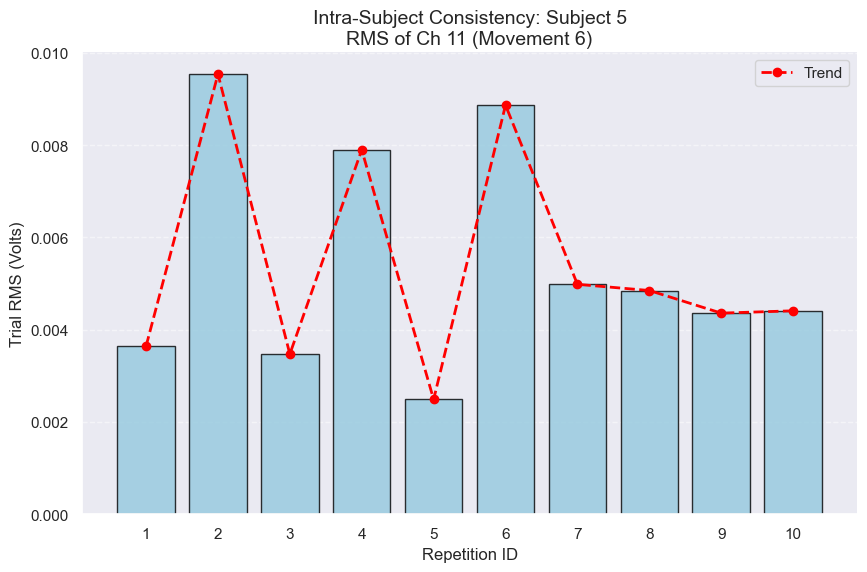

In [158]:
subject_id_to_plot = 5

df_single = df_all[df_all['Subject'] == subject_id_to_plot].copy()
df_single = df_single.sort_values(by='Repetition')

plt.figure(figsize=(10, 6))

sns.barplot(data=df_single, x='Repetition', y='Feature Value', 
            color='skyblue', edgecolor='black', alpha=0.8)

plt.plot(range(len(df_single)), df_single['Feature Value'].values, 
         color='red', marker='o', linestyle='--', linewidth=2, label='Trend')

plt.title(f"Intra-Subject Consistency: Subject {subject_id_to_plot}\n"
          f"{feature_name} of Ch {channel_idx+1} (Movement {target_mov})", fontsize=14)
plt.ylabel(f"Trial {feature_name} (Volts)", fontsize=12)
plt.xlabel("Repetition ID", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()

plt.show()

### Cross-validation

Fold 01, test subjects [1]: acc = 0.357, f1 = 0.300
Fold 02, test subjects [2]: acc = 0.208, f1 = 0.136
Fold 03, test subjects [3]: acc = 0.445, f1 = 0.417
Fold 04, test subjects [4]: acc = 0.300, f1 = 0.247
Fold 05, test subjects [5]: acc = 0.325, f1 = 0.291
Fold 06, test subjects [6]: acc = 0.300, f1 = 0.231
Fold 07, test subjects [7]: acc = 0.193, f1 = 0.170
Fold 08, test subjects [8]: acc = 0.425, f1 = 0.337
Fold 09, test subjects [9]: acc = 0.197, f1 = 0.143
Fold 10, test subjects [10]: acc = 0.350, f1 = 0.277
Fold 11, test subjects [11]: acc = 0.392, f1 = 0.285
Fold 12, test subjects [12]: acc = 0.291, f1 = 0.241
Fold 13, test subjects [13]: acc = 0.390, f1 = 0.313
Fold 14, test subjects [14]: acc = 0.375, f1 = 0.321
Fold 15, test subjects [15]: acc = 0.383, f1 = 0.321
Fold 16, test subjects [16]: acc = 0.292, f1 = 0.254
Fold 17, test subjects [17]: acc = 0.508, f1 = 0.463
Fold 18, test subjects [18]: acc = 0.276, f1 = 0.260
Fold 19, test subjects [19]: acc = 0.187, f1 = 0.123
Fo

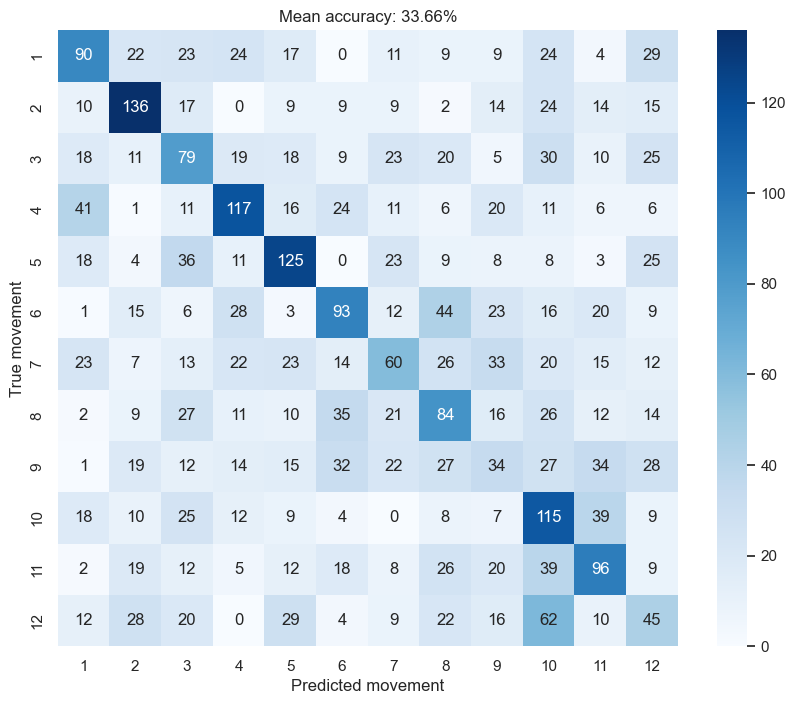

In [ ]:
# 1. Build trial level dataset per subject directly from cleaned files
def build_subject_dataset(emg_output_dir):
    dataset = []

    for subj in range(1, 28):
        s = f"s{subj}"
        cleaned_path = Path(emg_output_dir) / s / f"{s}_ex1_cleaned.npz"

        if not cleaned_path.exists():
            print(f"Skip {s} no cleaned file")
            continue

        data = np.load(cleaned_path, allow_pickle=True)
        X_raw = data["emg"]
        y_raw = data["restimulus"]
        rep_raw = data["rerepetition"]

        # your existing function: from raw samples to trial features
        X_trials, y_trials = build_trial_dataset(X_raw, y_raw, rep_raw)

        dataset.append({
            "subject": subj,
            "X": X_trials,
            "y": y_trials,
        })

    return dataset


# 2. Stack all subjects into X, y, groups
dataset = build_subject_dataset(EMG_OUTPUT_DIR)

X = np.concatenate([subj["X"] for subj in dataset], axis=0)
y = np.concatenate([subj["y"] for subj in dataset], axis=0)

# groups encode which subject each trial comes from
groups = np.concatenate([
    np.full(len(subj["y"]), subj["subject"])
    for subj in dataset
])


# 3. Group CV with SVM and StandardScaler
def run_group_svm_cv(X, y, groups, n_groups=1, C=0.1, gamma="scale", kernel="linear"):
    if n_groups == 1:
        splitter = LeaveOneGroupOut()
    else:
        splitter = LeavePGroupsOut(n_groups=n_groups)

    scores = []
    all_y_true = []
    all_y_pred = []

    for fold_idx, (train_idx, test_idx) in enumerate(splitter.split(X, y, groups), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # scale inside each fold using only train data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        clf = SVC(C=C, gamma=gamma, kernel=kernel)
        clf.fit(X_train_scaled, y_train)

        y_pred = clf.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        f1  = f1_score(y_test, y_pred, average="macro")
        
        scores.append(acc)

        all_y_true.append(y_test)
        all_y_pred.append(y_pred)

        test_subjs = np.unique(groups[test_idx])
        print(f"Fold {fold_idx:02d}, test subjects {test_subjs}: acc = {acc:.3f}, f1 = {f1:.3f}")

    scores = np.array(scores)
    all_y_true = np.concatenate(all_y_true)
    all_y_pred = np.concatenate(all_y_pred)

    print(f"\nMean accuracy: {scores.mean():.3f} +- {scores.std():.3f}")

    class_names = [f"Mov {i}" for i in np.unique(all_y_true)]
    print("\nClassification report over all folds:")
    print(classification_report(all_y_true, all_y_pred, target_names=class_names))

    cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=np.unique(all_y_true),
        yticklabels=np.unique(all_y_true),
    )
    plt.title(f"Mean accuracy: {scores.mean():.2%}")
    plt.xlabel("Predicted movement")
    plt.ylabel("True movement")
    plt.show()

    return scores, all_y_true, all_y_pred


# 4. LOSO (leave one subject out)
loso_scores, loso_y_true, loso_y_pred = run_group_svm_cv(
    X, y, groups,
    n_groups=1,      # 1 subject held out => LOSO
    C=1.0,
    gamma="scale",
    kernel="rbf",
)


In [172]:
pd.Series(loso_scores).describe()


count    27.000000
mean      0.336595
std       0.108151
min       0.186813
25%       0.256285
50%       0.325000
75%       0.390749
max       0.575000
dtype: float64

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_scaled_debug(X_train, X_train_scaled, y_train, fold_idx, max_feats=20):
    n_feats = X_train.shape[1]
    feats = np.arange(min(n_feats, max_feats))

    # 1) Per-feature mean/std before vs after (should go ~0 mean, ~1 std after)
    mu_raw  = X_train[:, feats].mean(axis=0)
    sd_raw  = X_train[:, feats].std(axis=0, ddof=0)
    mu_scl  = X_train_scaled[:, feats].mean(axis=0)
    sd_scl  = X_train_scaled[:, feats].std(axis=0, ddof=0)

    plt.figure(figsize=(10, 4))
    plt.plot(mu_raw, label="mean raw")
    plt.plot(mu_scl, label="mean scaled")
    plt.title(f"Fold {fold_idx} train feature means (first {len(feats)} feats)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(sd_raw, label="std raw")
    plt.plot(sd_scl, label="std scaled")
    plt.title(f"Fold {fold_idx} train feature stds (first {len(feats)} feats)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) Histograms for a few features
    k = min(6, len(feats))
    show_feats = feats[:k]
    plt.figure(figsize=(12, 6))
    for i, f in enumerate(show_feats, start=1):
        plt.subplot(2, 3, i)
        plt.hist(X_train[:, f], bins=40, alpha=0.6, label="raw")
        plt.hist(X_train_scaled[:, f], bins=40, alpha=0.6, label="scaled")
        plt.title(f"feat {f}")
        if i == 1:
            plt.legend()
    plt.suptitle(f"Fold {fold_idx} train: raw vs scaled feature distributions")
    plt.tight_layout()
    plt.show()

    # 3) PCA 2D view (scaled space)
    pca = PCA(n_components=2, random_state=0)
    Z = pca.fit_transform(X_train_scaled)

    plt.figure(figsize=(7, 6))
    sc = plt.scatter(Z[:, 0], Z[:, 1], s=8, alpha=0.7, c=y_train)
    plt.title(f"Fold {fold_idx} train PCA(2) of SCALED features")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(sc, label="class")
    plt.tight_layout()
    plt.show()




In [161]:

#   {"subject": subj_id, "X": X_trials, "y": y_trials},
#   ...
# ]
# built earlier by build_subject_dataset(EMG_OUTPUT_DIR)

# 1. fix test subject
test_subj = 27  # as in the assignment example

# make sure dataset is sorted by subject id
dataset_sorted = sorted(dataset, key=lambda d: d["subject"])

# extract test data
test_entry = [d for d in dataset_sorted if d["subject"] == test_subj]
if len(test_entry) != 1:
    raise ValueError(f"Test subject {test_subj} not found or duplicated")
test_entry = test_entry[0]

X_test = test_entry["X"]
y_test = test_entry["y"]

# list of training subjects (all except test_subj)
train_entries = [d for d in dataset_sorted if d["subject"] != test_subj]

train_subject_ids = [d["subject"] for d in train_entries]
print("Train subjects (order):", train_subject_ids)
print("Test subject:", test_subj)

n_train_list = []
acc_list = []
f1_list = []
# 2. grow training set: first 1 subject, then 2, then 3, ...
for k in range(1, len(train_entries) + 1):
    subset = train_entries[:k]

    X_train = np.concatenate([d["X"] for d in subset], axis=0)
    y_train = np.concatenate([d["y"] for d in subset], axis=0)

    # scale using only current train data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = SVC(C=0.1, gamma="scale", kernel="linear")
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")
    
    n_train_subj = k
    n_train_list.append(n_train_subj)
    acc_list.append(acc)
    f1_list.append(f1)

    used_ids = [d["subject"] for d in subset]
    print(f"Train subjects {used_ids} (n={n_train_subj}) -> test subj {test_subj}: acc = {acc:.3f}, f1 = {f1:.3f}")

# put into array for later plotting
n_train_arr = np.array(n_train_list)
acc_arr = np.array(acc_list)
f1_arr = np.array(f1_list)

print("\nTraining subjects vs accuracy on test subject", test_subj)
for n, a in zip(n_train_arr, acc_arr):
    print(f"{n} subjects -> acc = {a:.3f}")


Train subjects (order): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
Test subject: 27
Train subjects [1] (n=1) -> test subj 27: acc = 0.200, f1 = 0.176
Train subjects [1, 2] (n=2) -> test subj 27: acc = 0.142, f1 = 0.120
Train subjects [1, 2, 3] (n=3) -> test subj 27: acc = 0.183, f1 = 0.138
Train subjects [1, 2, 3, 4] (n=4) -> test subj 27: acc = 0.100, f1 = 0.071
Train subjects [1, 2, 3, 4, 5] (n=5) -> test subj 27: acc = 0.075, f1 = 0.058
Train subjects [1, 2, 3, 4, 5, 6] (n=6) -> test subj 27: acc = 0.100, f1 = 0.081
Train subjects [1, 2, 3, 4, 5, 6, 7] (n=7) -> test subj 27: acc = 0.158, f1 = 0.099
Train subjects [1, 2, 3, 4, 5, 6, 7, 8] (n=8) -> test subj 27: acc = 0.158, f1 = 0.101
Train subjects [1, 2, 3, 4, 5, 6, 7, 8, 9] (n=9) -> test subj 27: acc = 0.158, f1 = 0.115
Train subjects [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] (n=10) -> test subj 27: acc = 0.167, f1 = 0.142
Train subjects [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] (n=11) -> test 

In [162]:
acc_arr

array([0.2       , 0.14166667, 0.18333333, 0.1       , 0.075     ,
       0.1       , 0.15833333, 0.15833333, 0.15833333, 0.16666667,
       0.125     , 0.125     , 0.13333333, 0.13333333, 0.13333333,
       0.125     , 0.125     , 0.11666667, 0.14166667, 0.14166667,
       0.15833333, 0.21666667, 0.175     , 0.175     , 0.18333333,
       0.20833333])

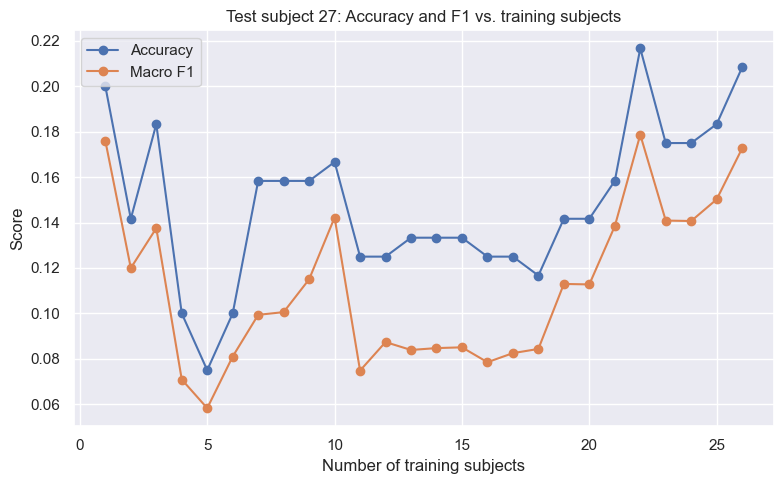

In [163]:
plt.figure(figsize=(8,5))
plt.plot(n_train_arr, acc_arr, marker="o", label="Accuracy")
plt.plot(n_train_arr, f1_arr,  marker="o", label="Macro F1")

plt.xlabel("Number of training subjects")
plt.ylabel("Score")
plt.title(f"Test subject {test_subj}: Accuracy and F1 vs. training subjects")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
